# STEP 1: Data Segmentation, Labeling and Visualization

Processing lateral_left.csv...


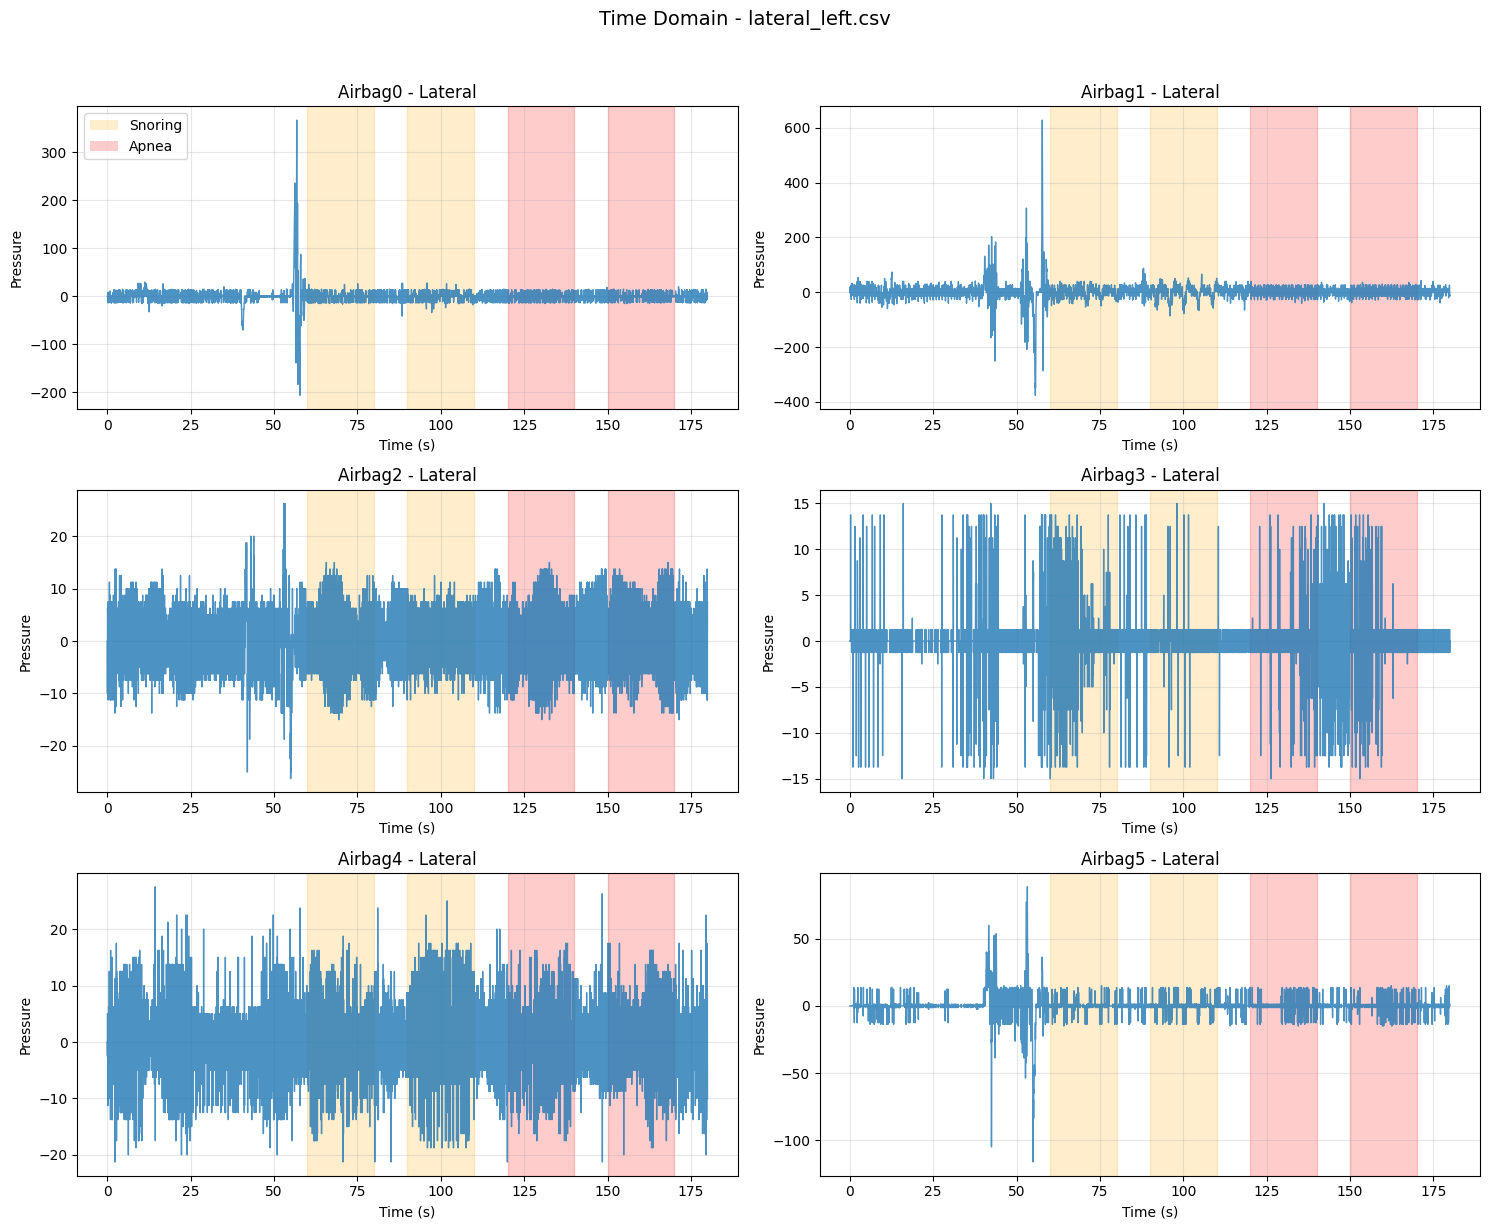

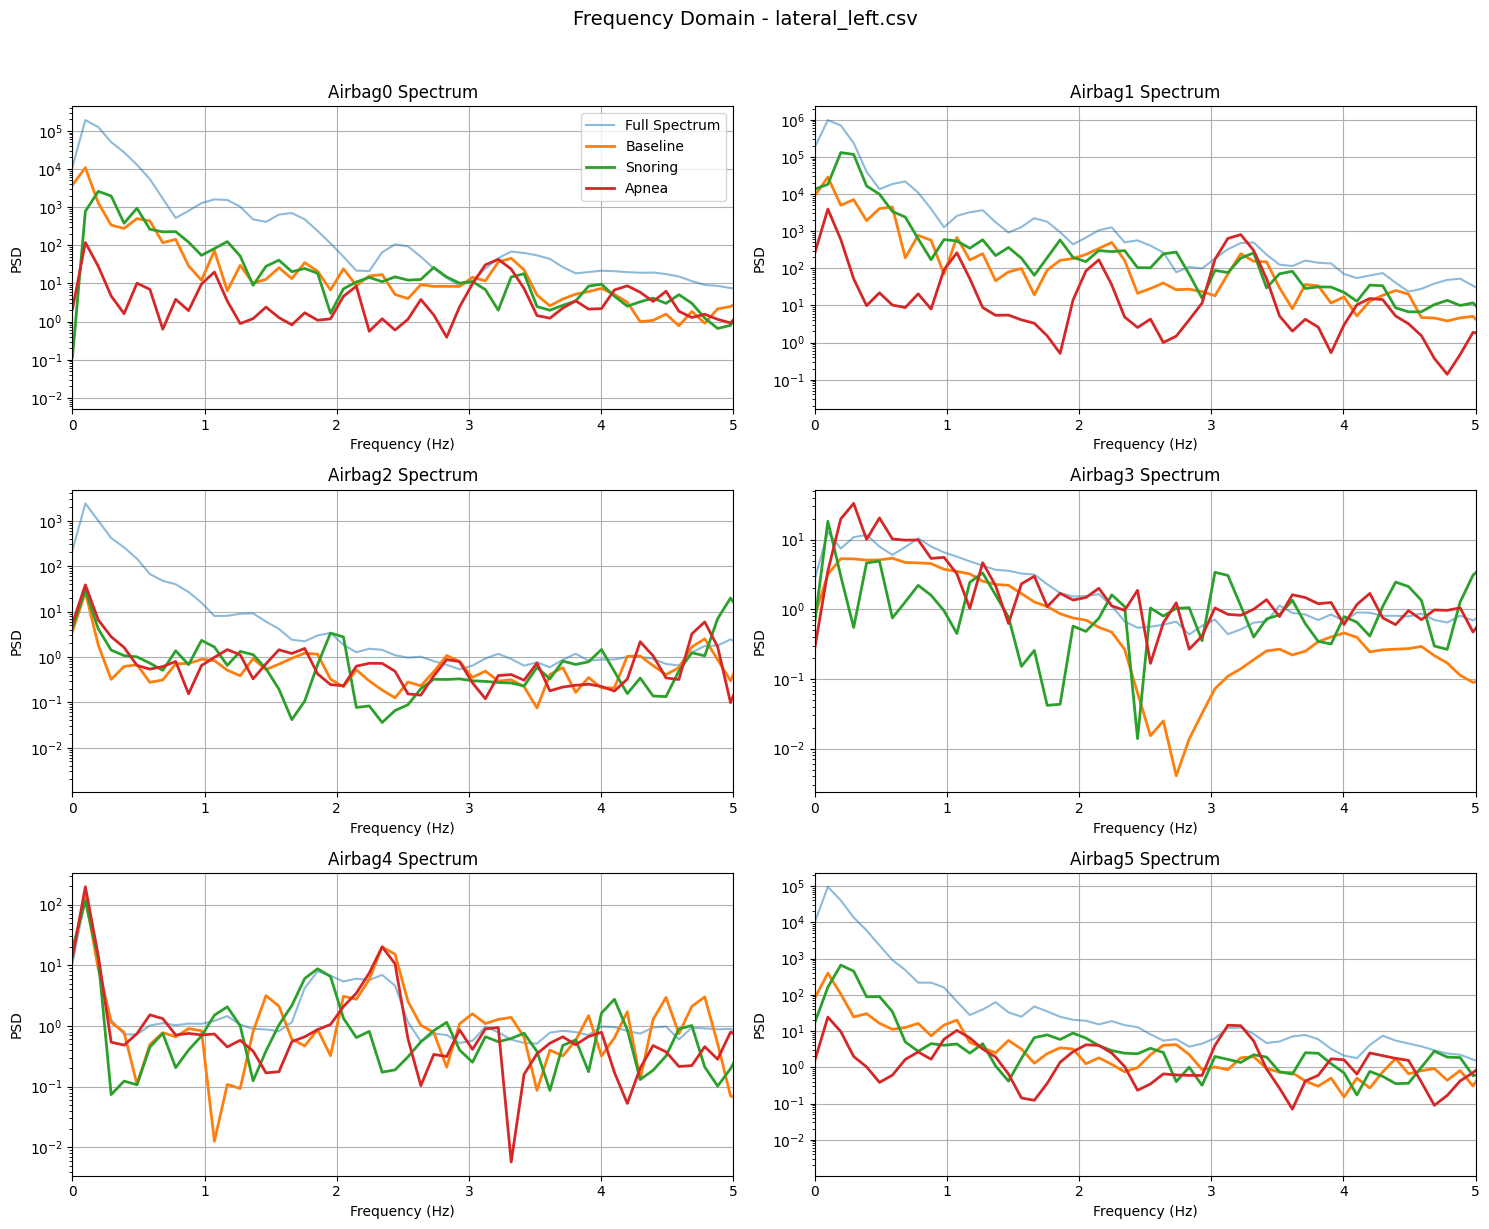

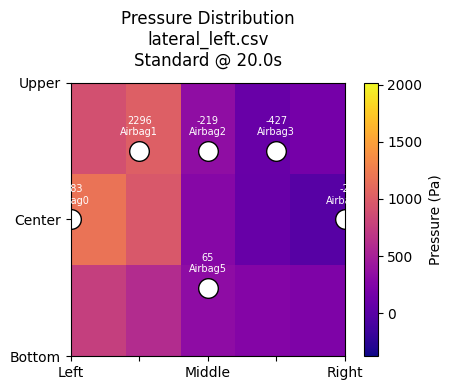

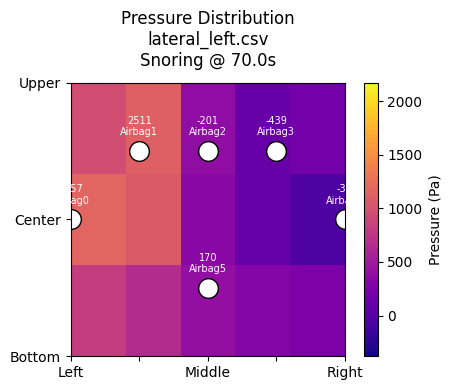

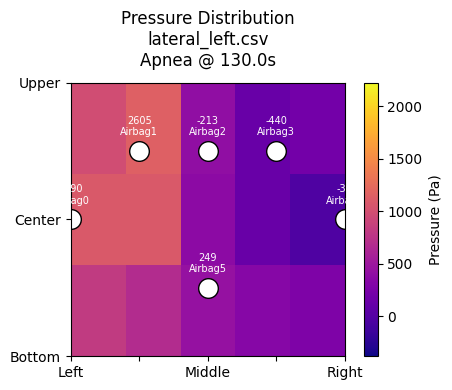

Processing lateral_middle.csv...


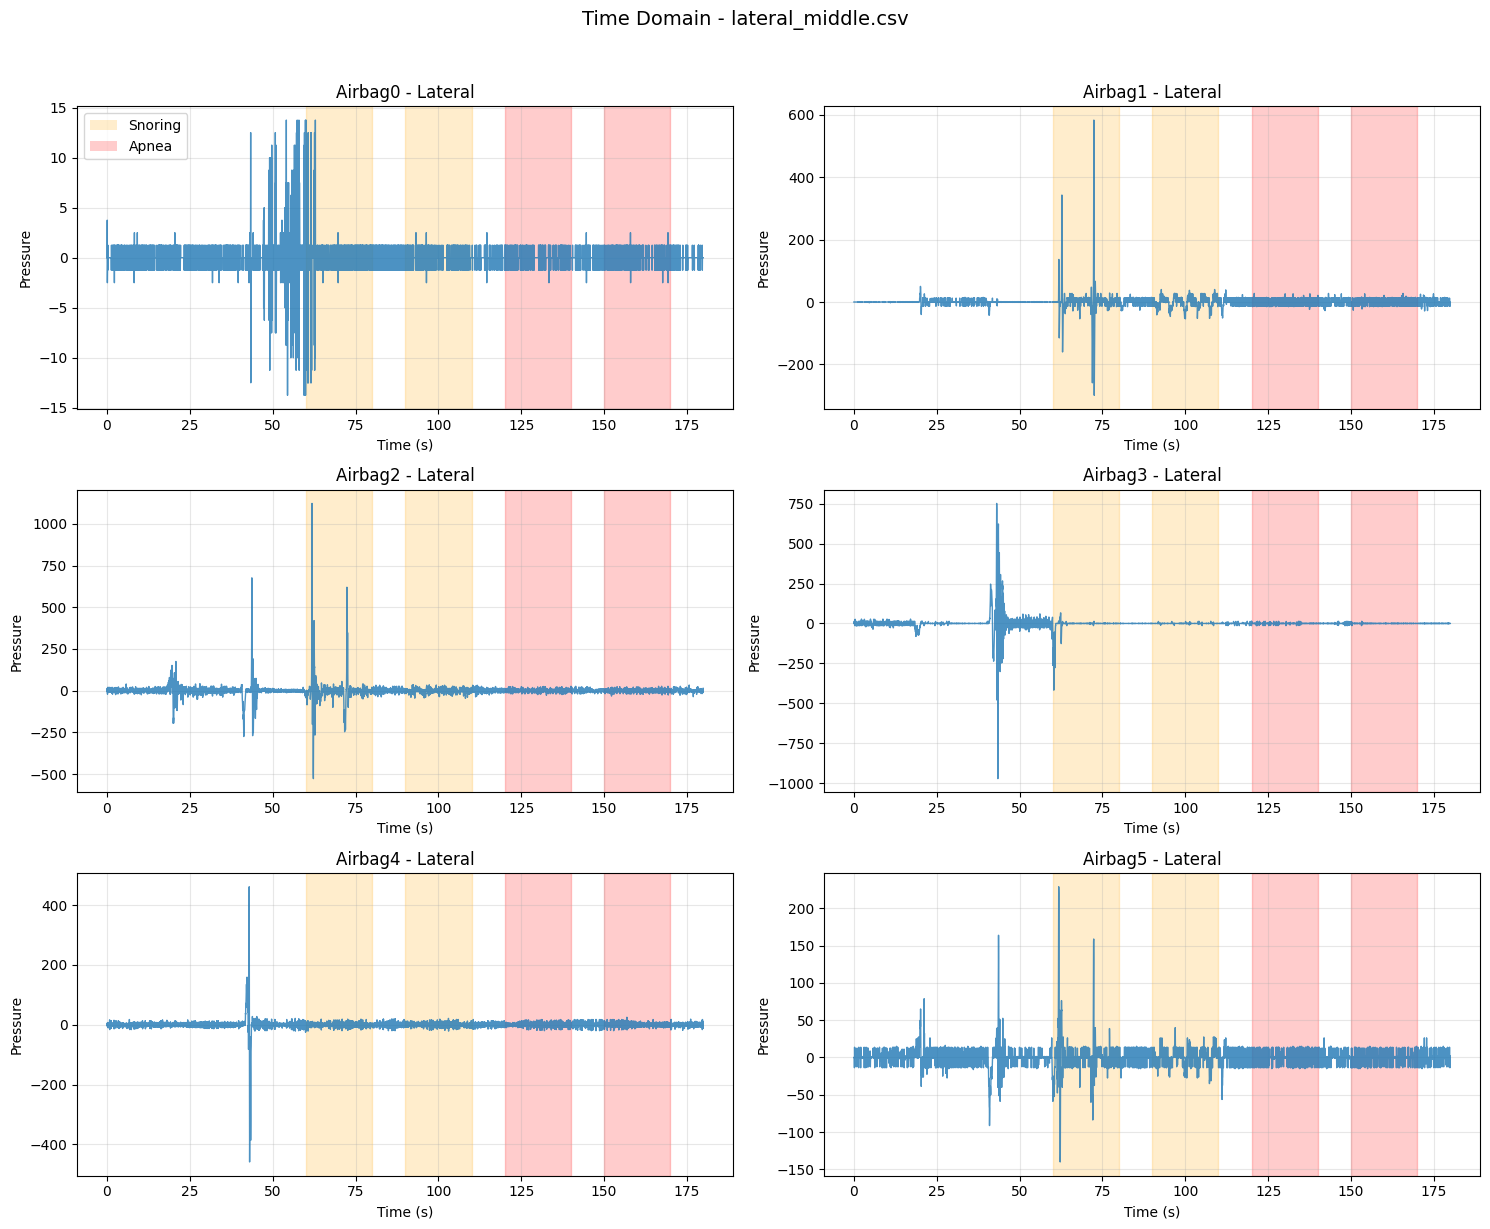

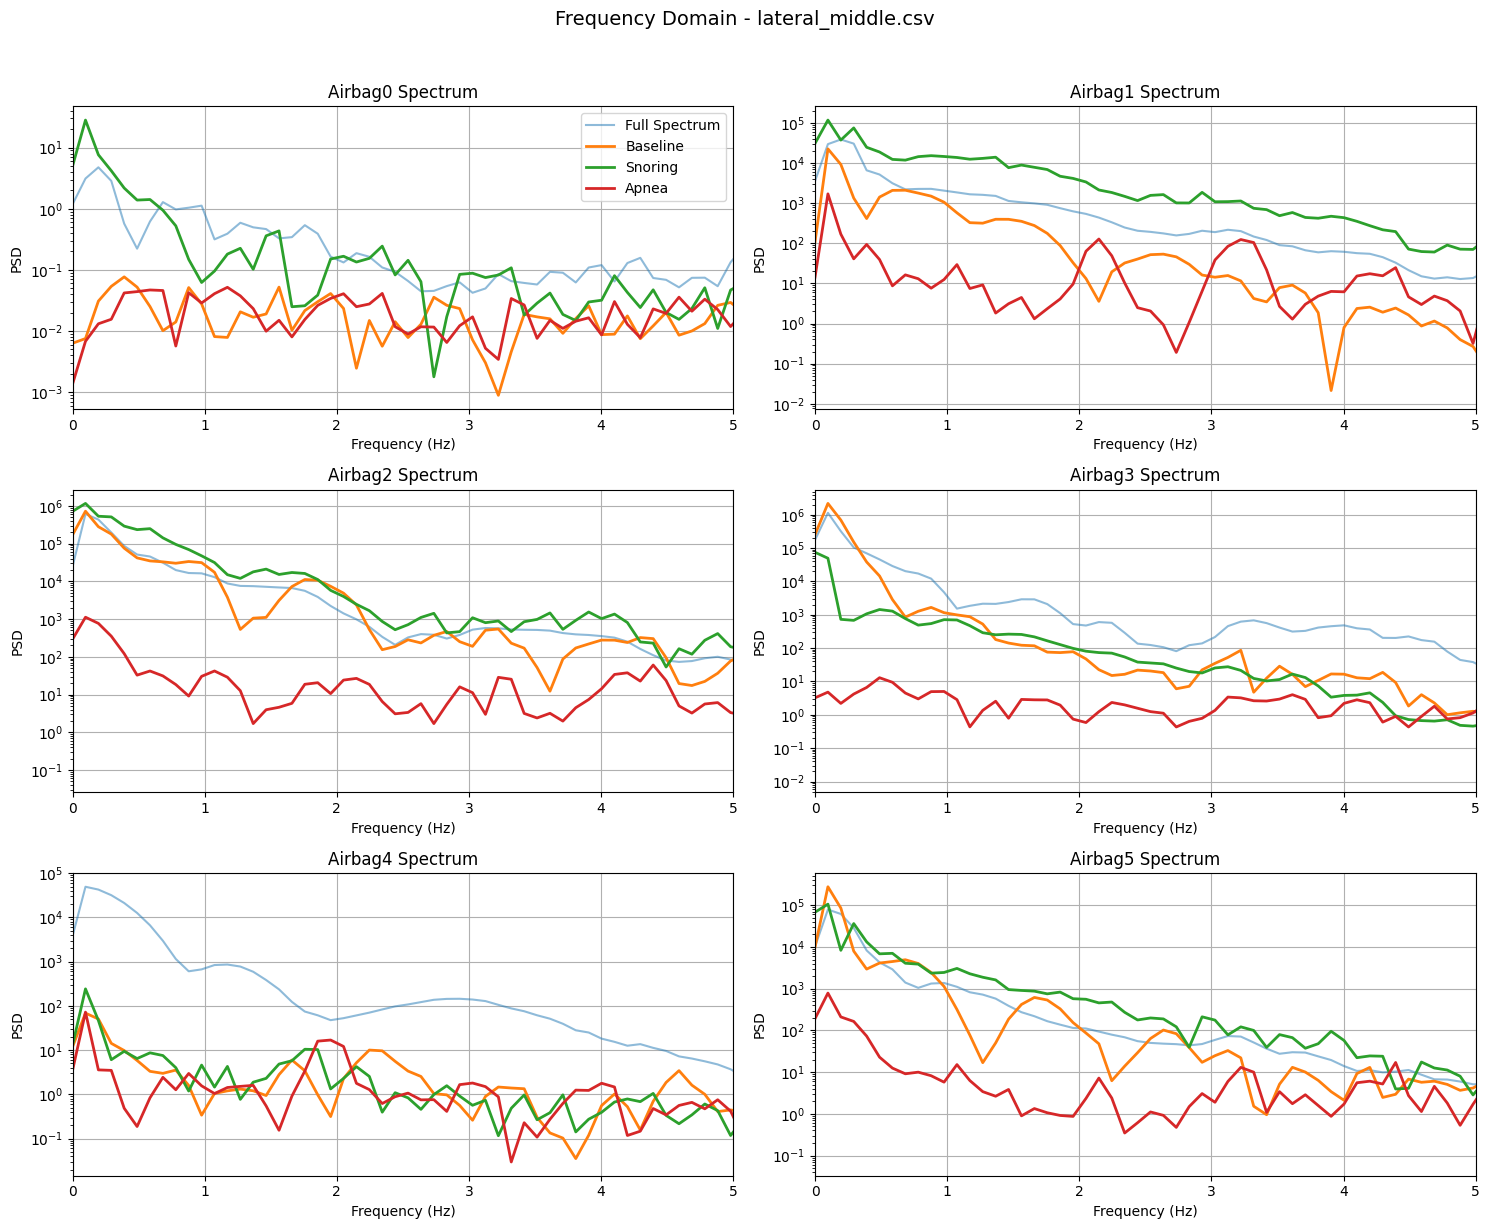

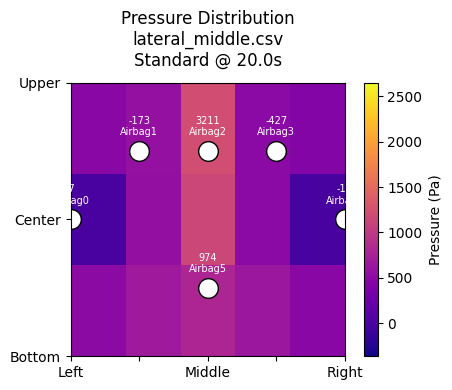

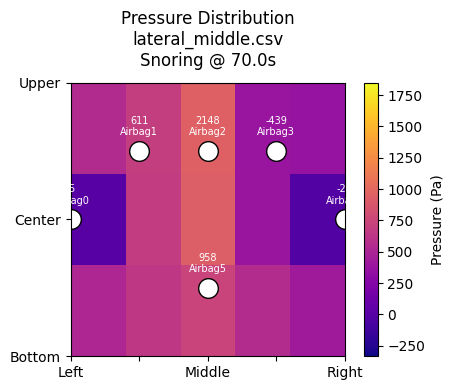

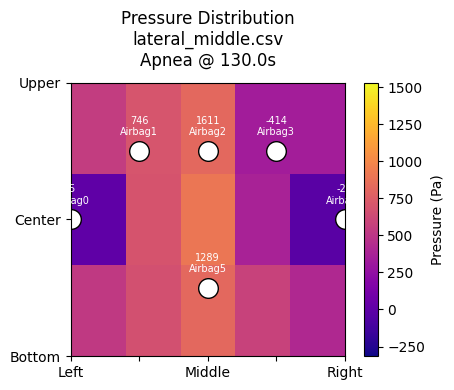

Processing lateral_right.csv...


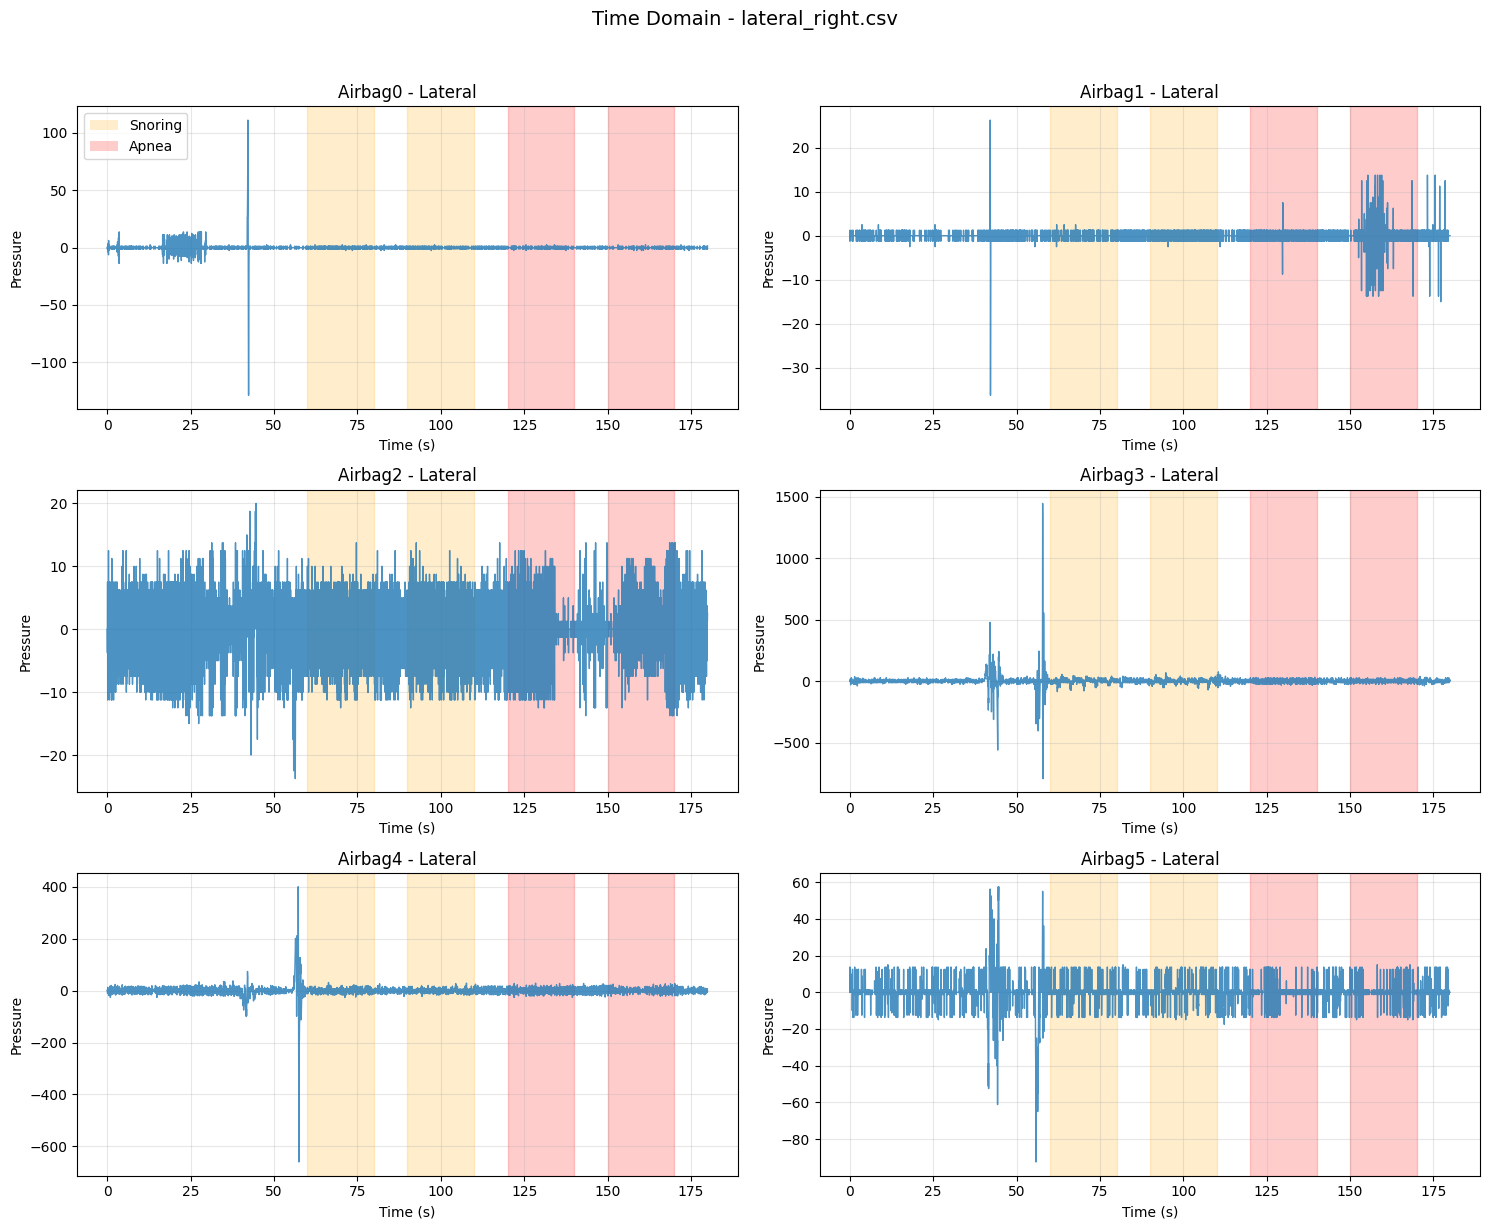

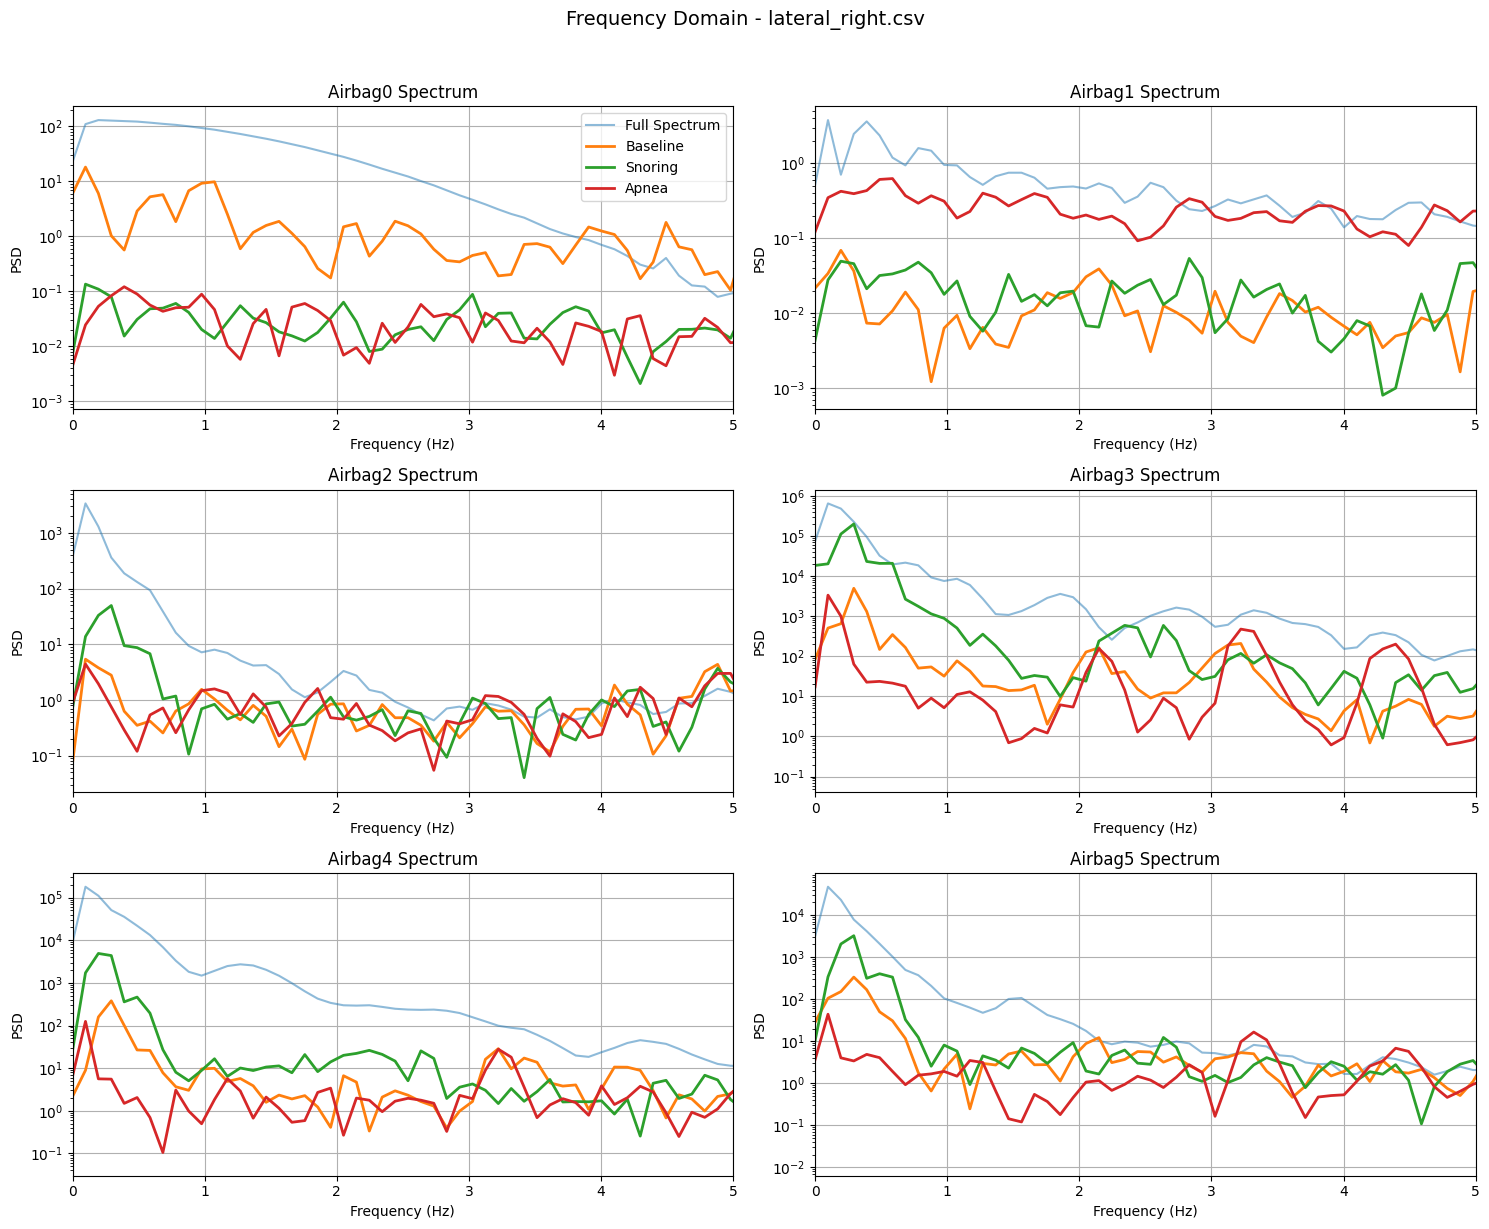

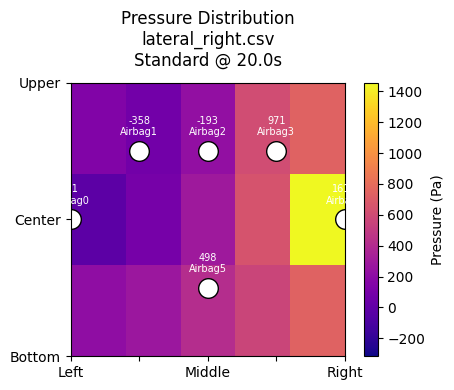

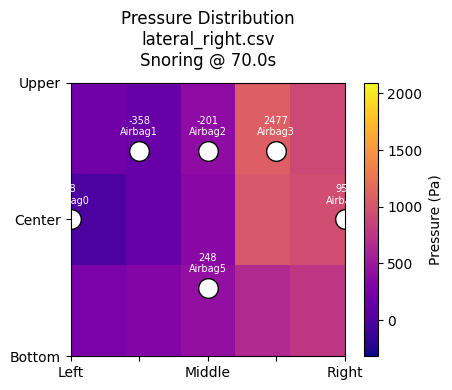

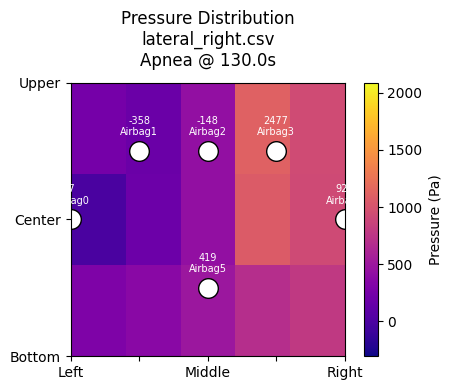

Processing prone_left.csv...


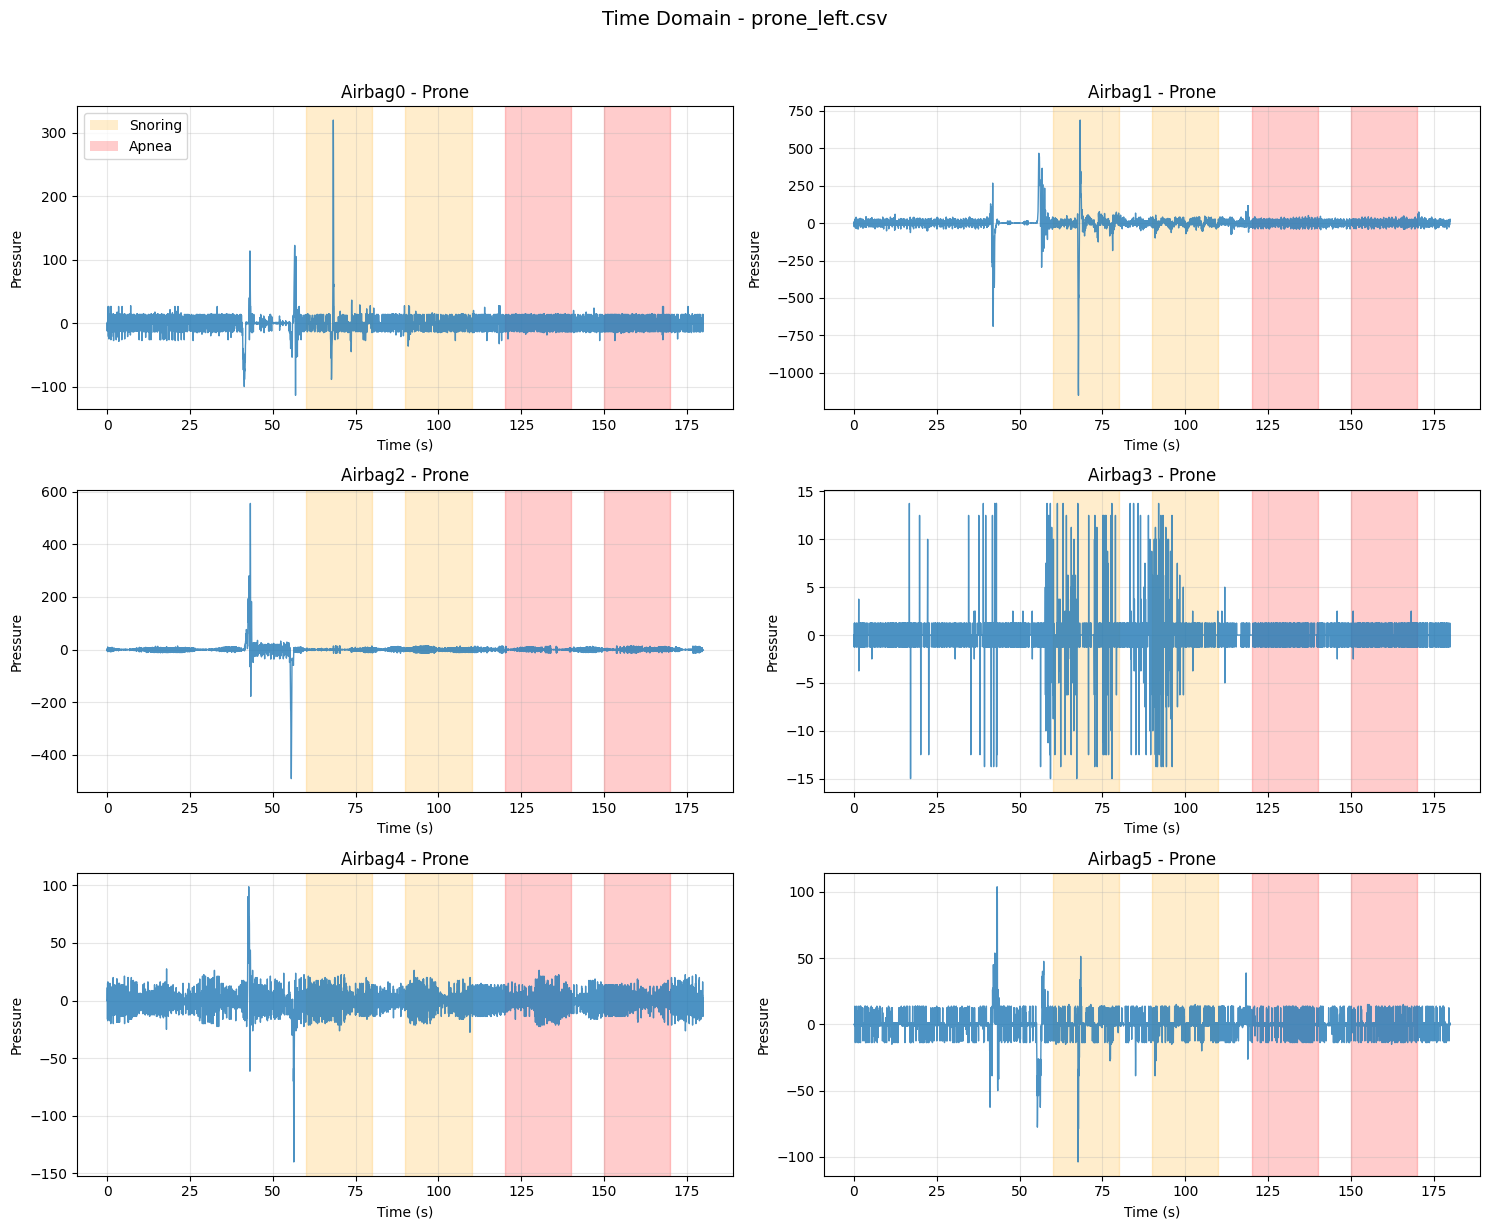

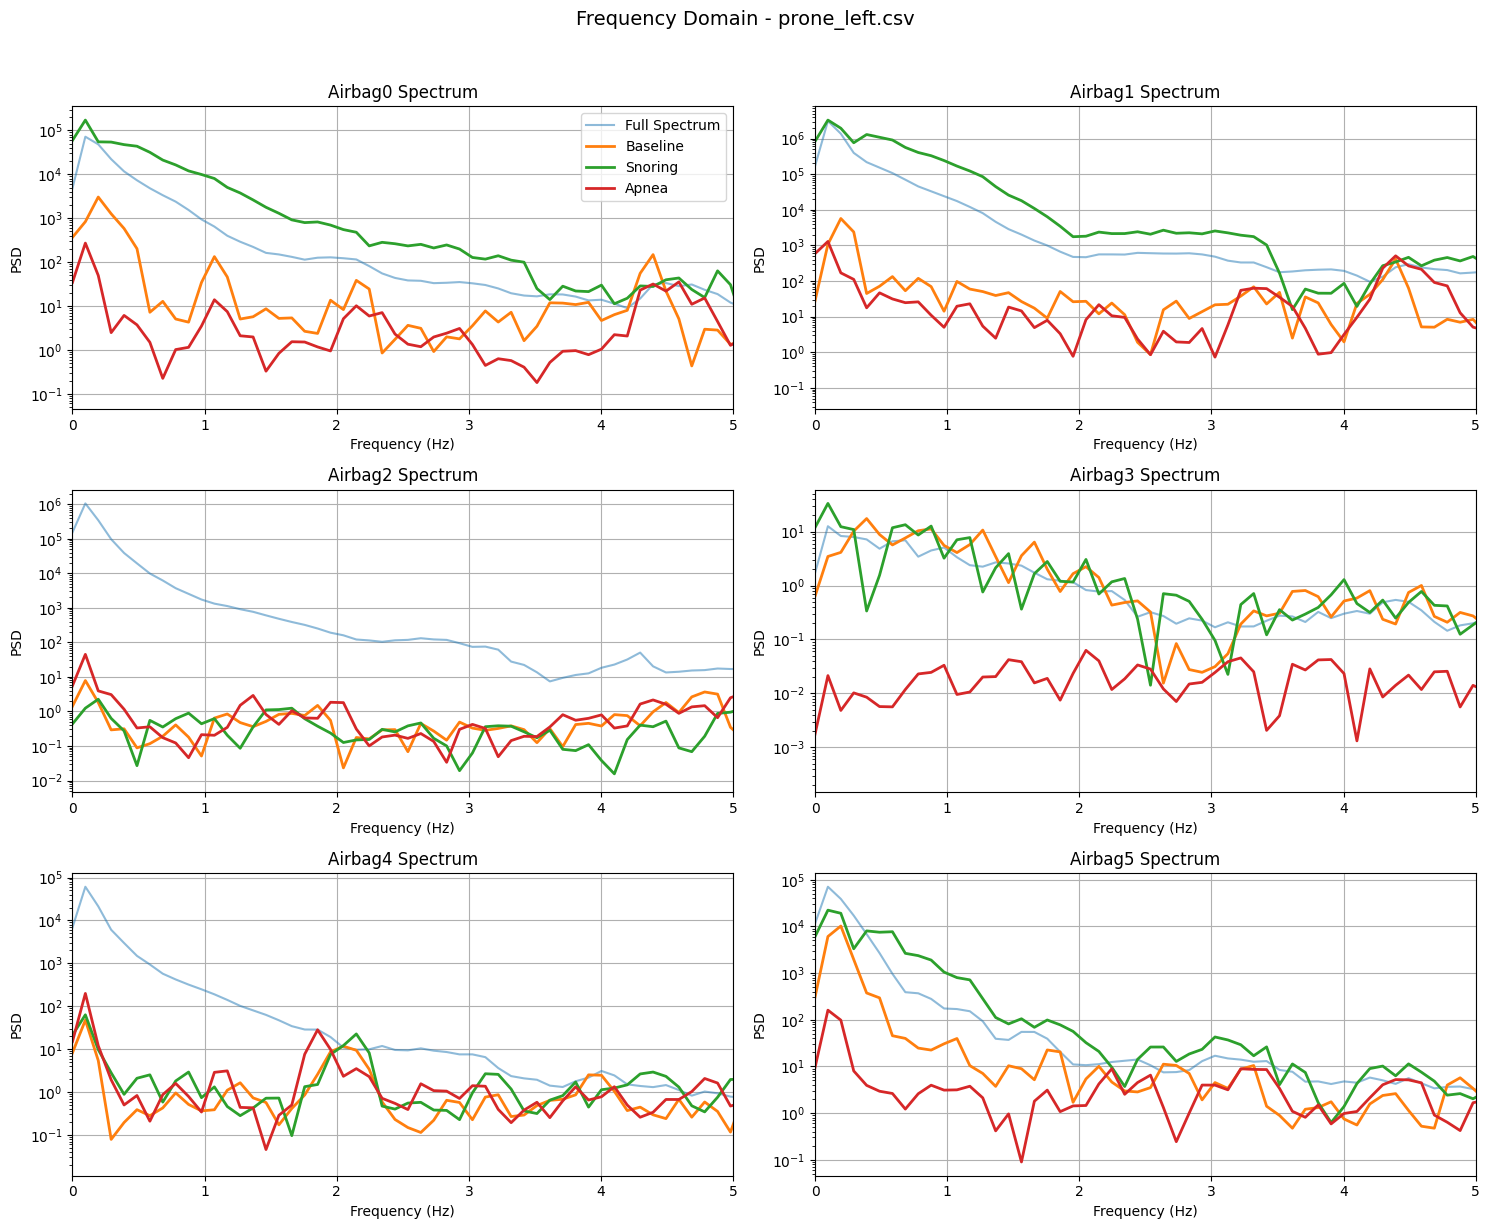

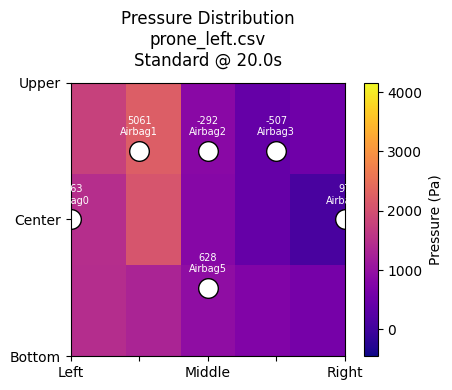

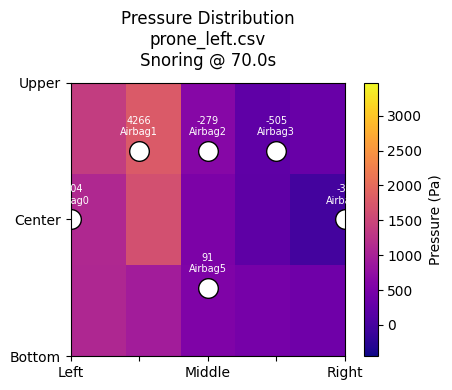

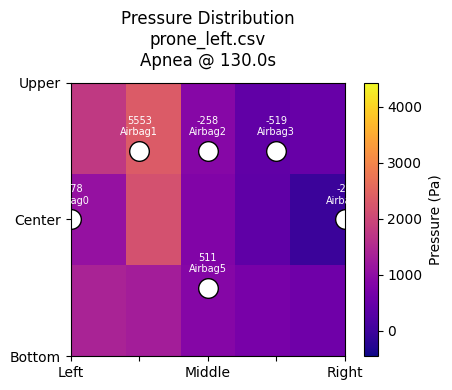

Processing prone_middle.csv...


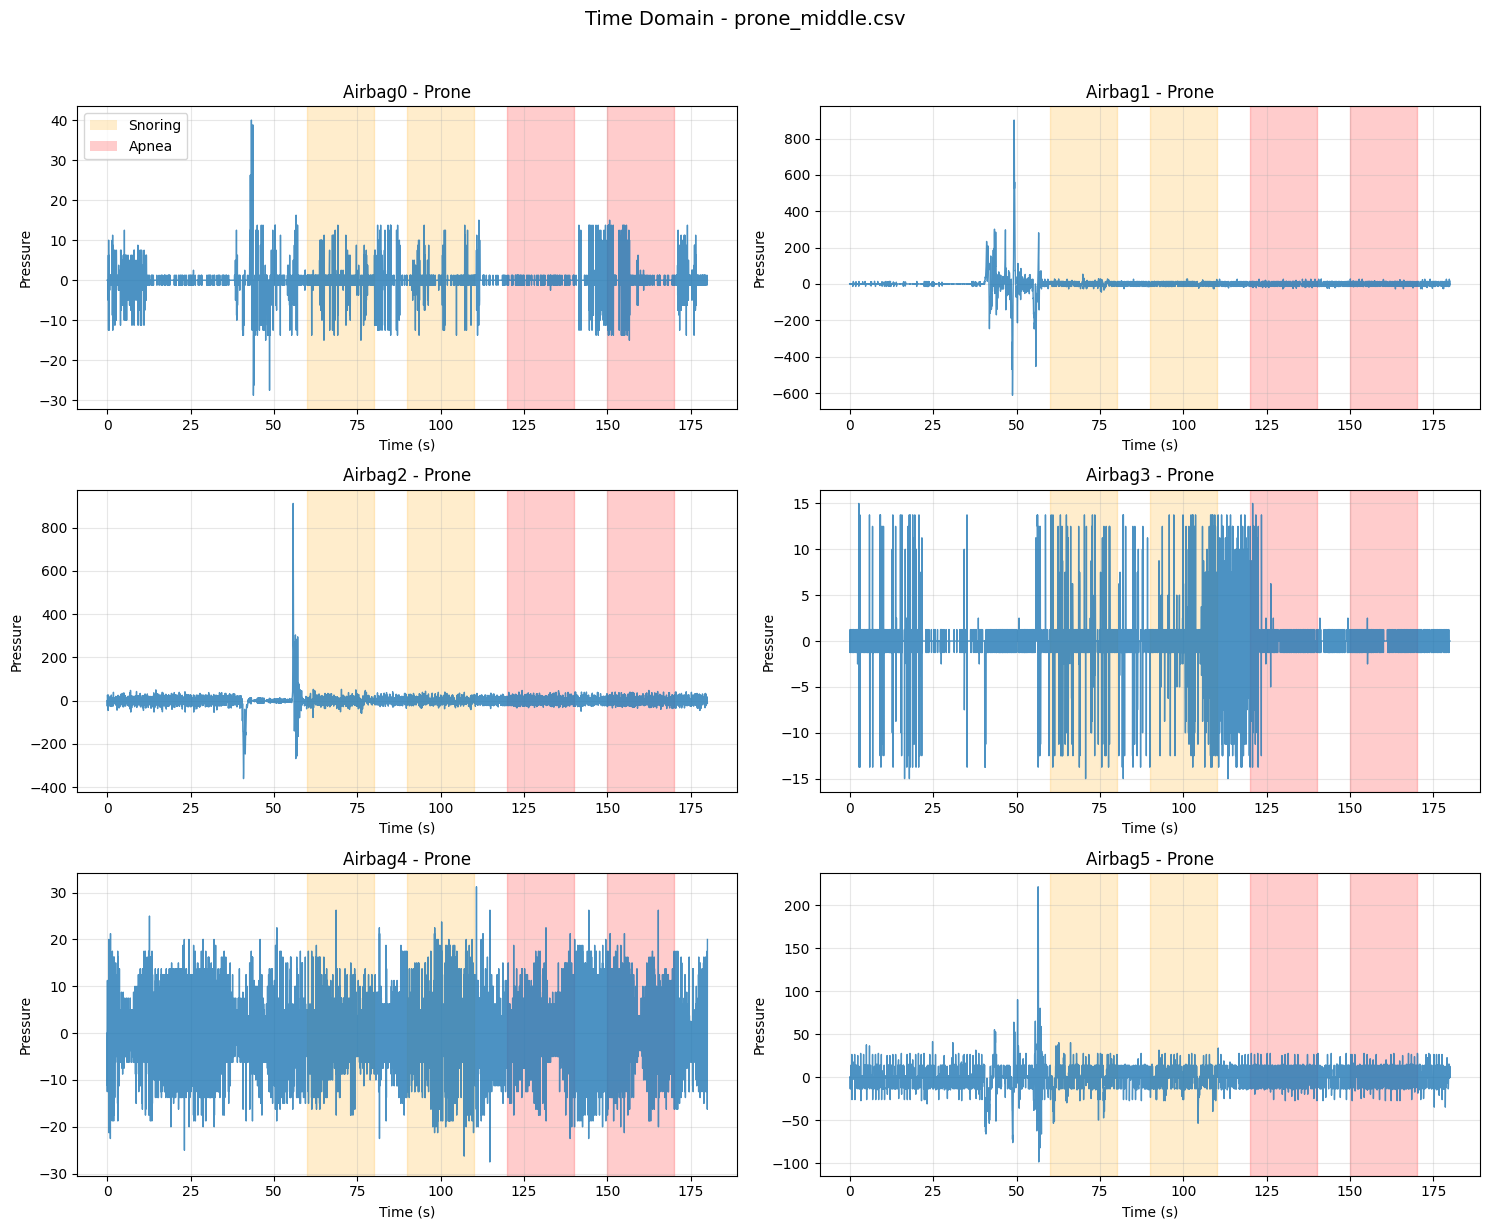

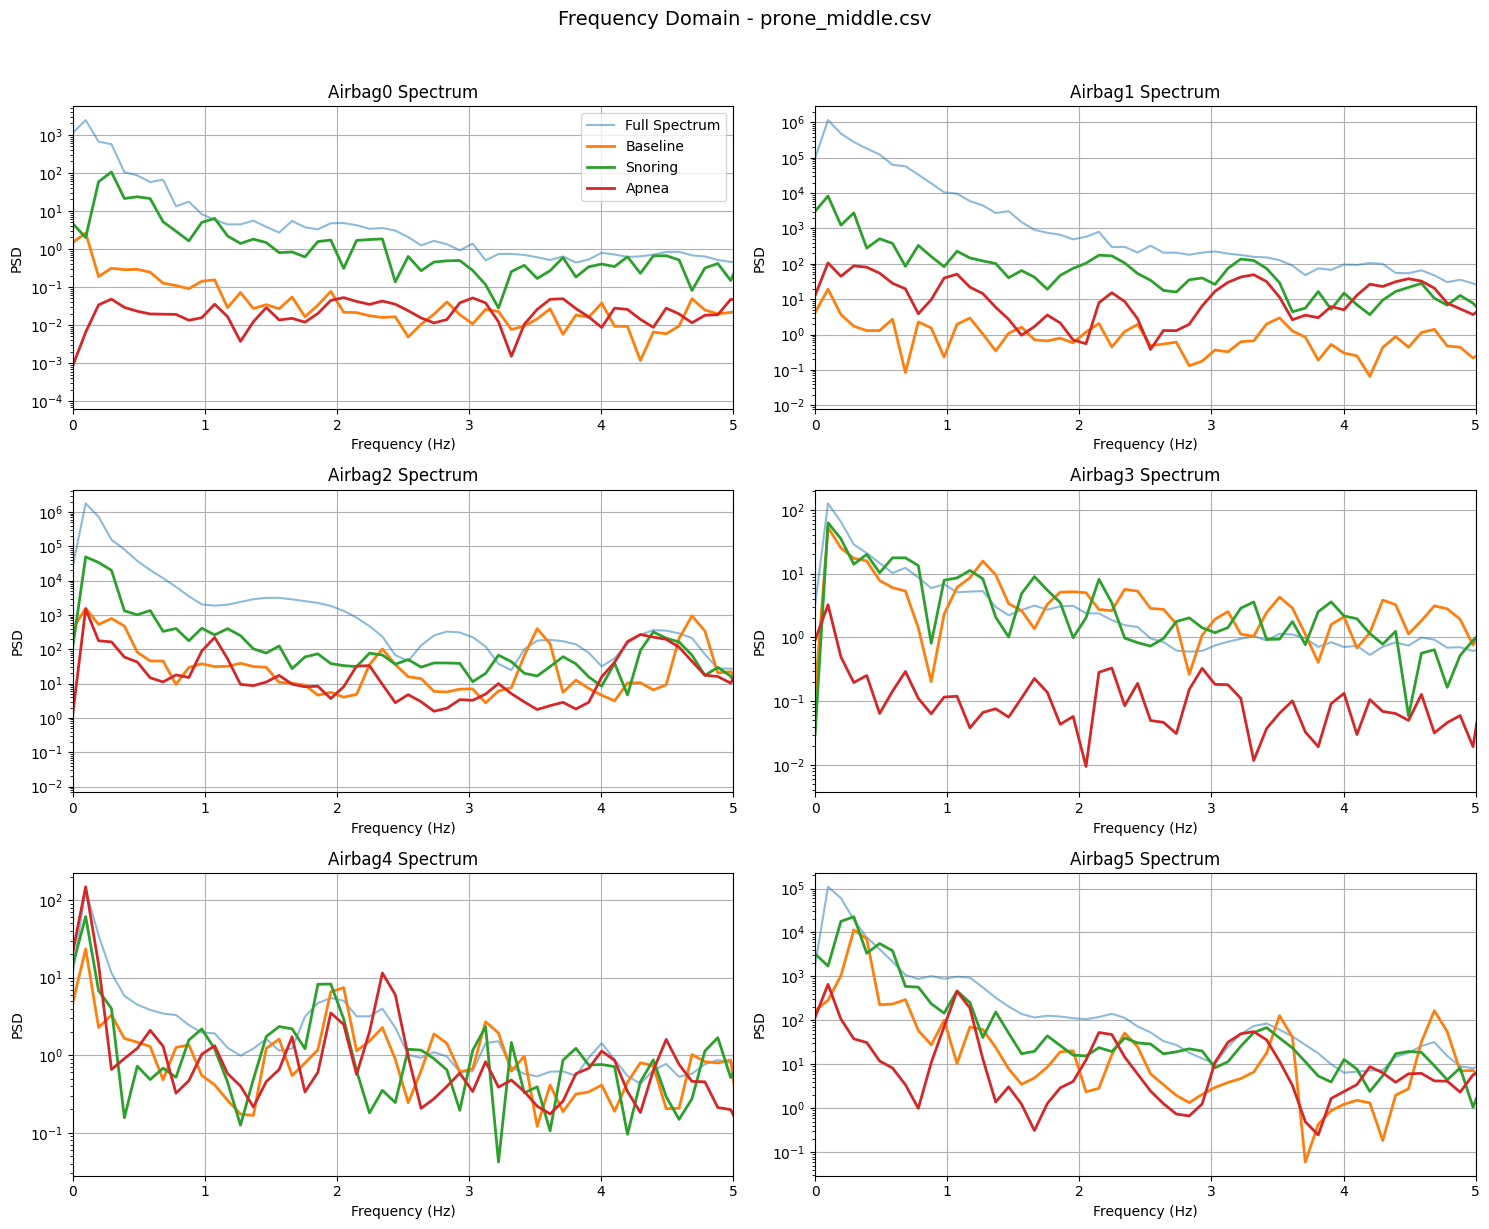

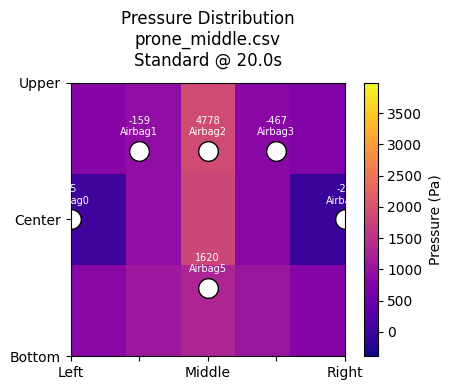

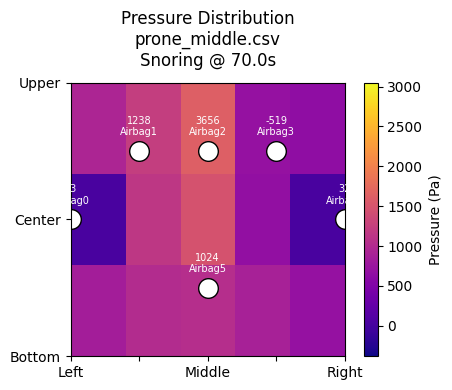

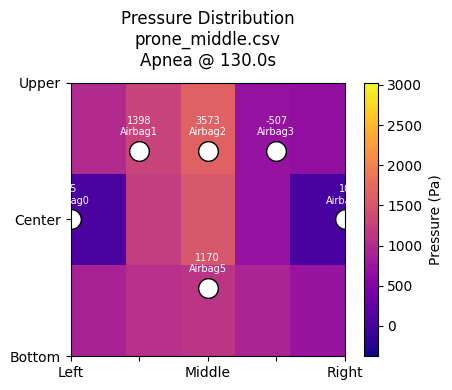

Processing prone_right.csv...


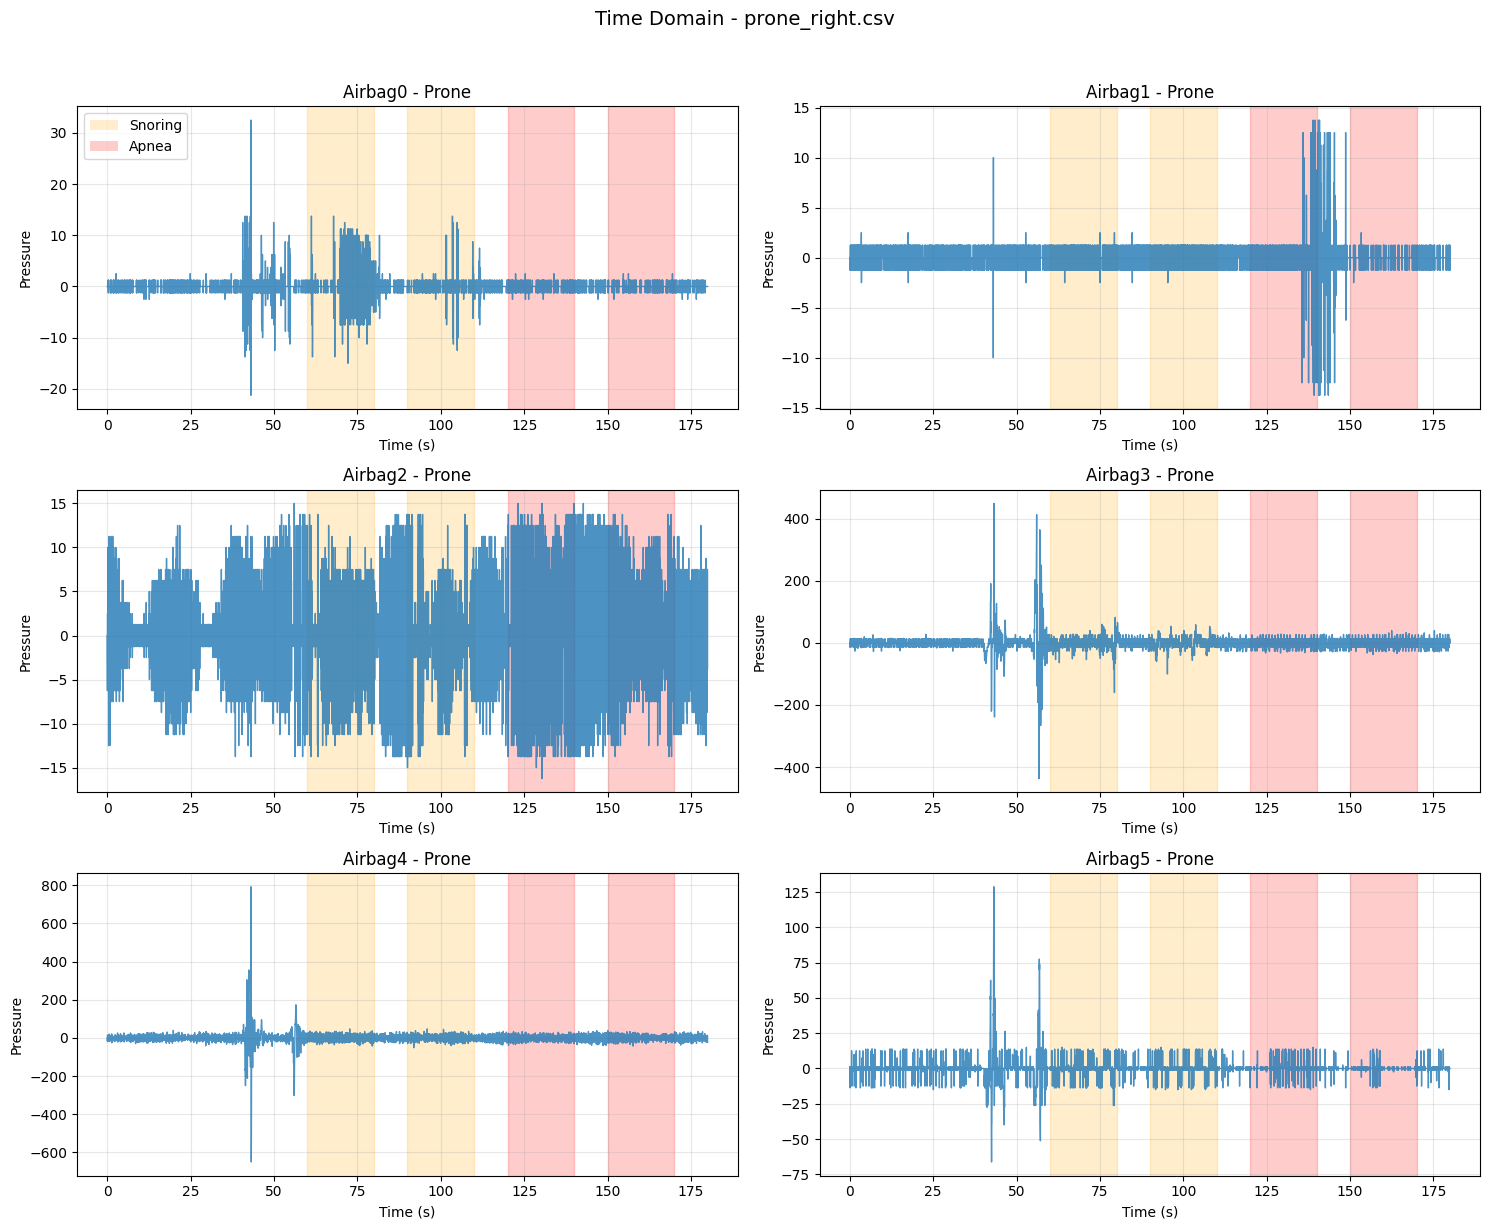

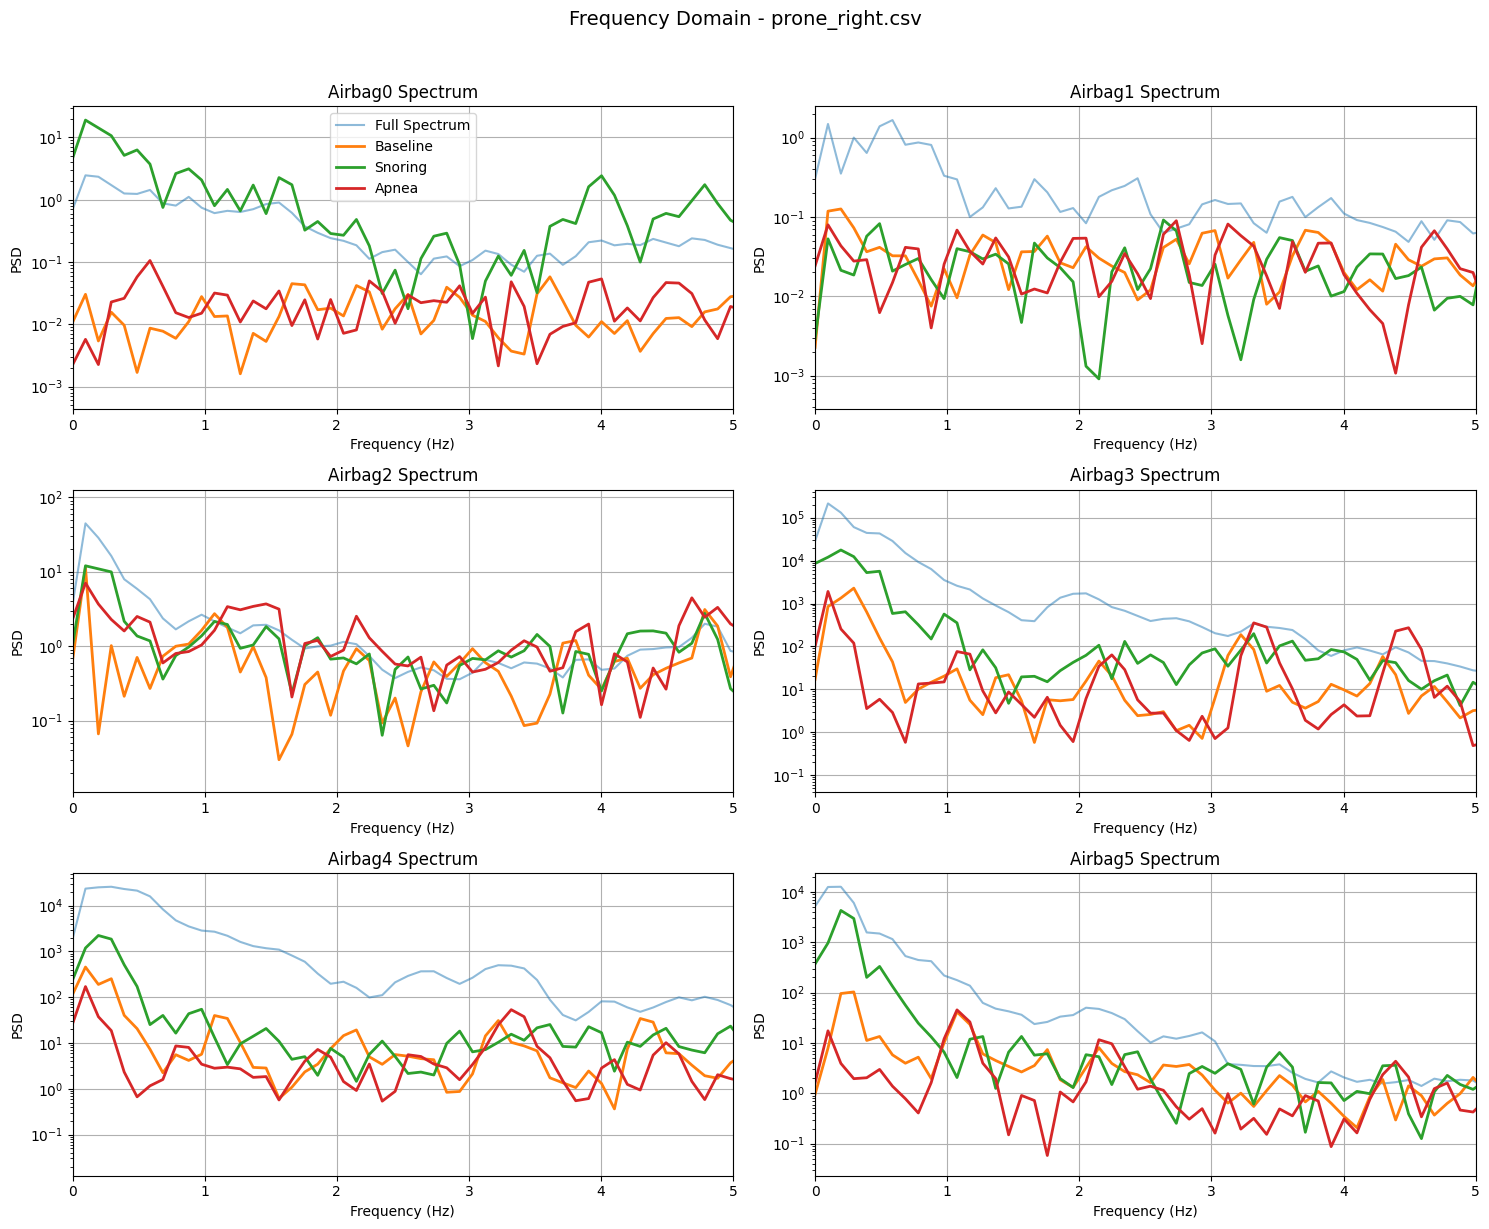

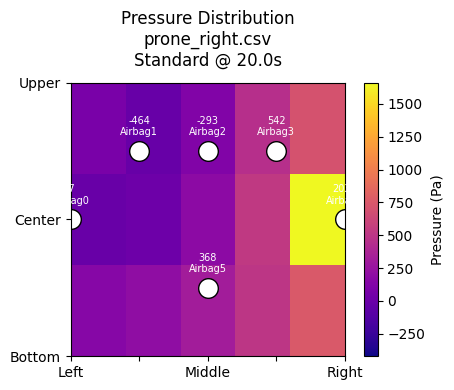

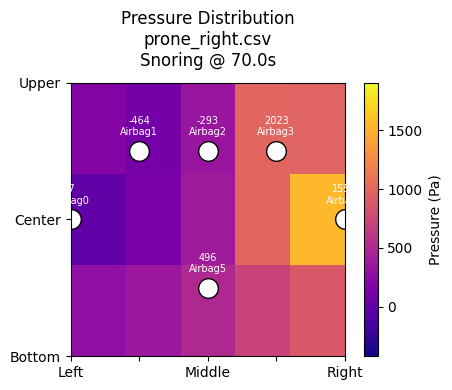

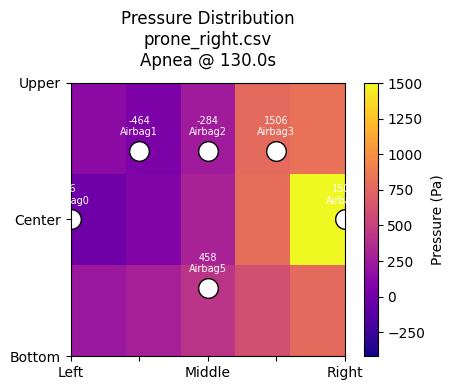

Processing supine_left.csv...


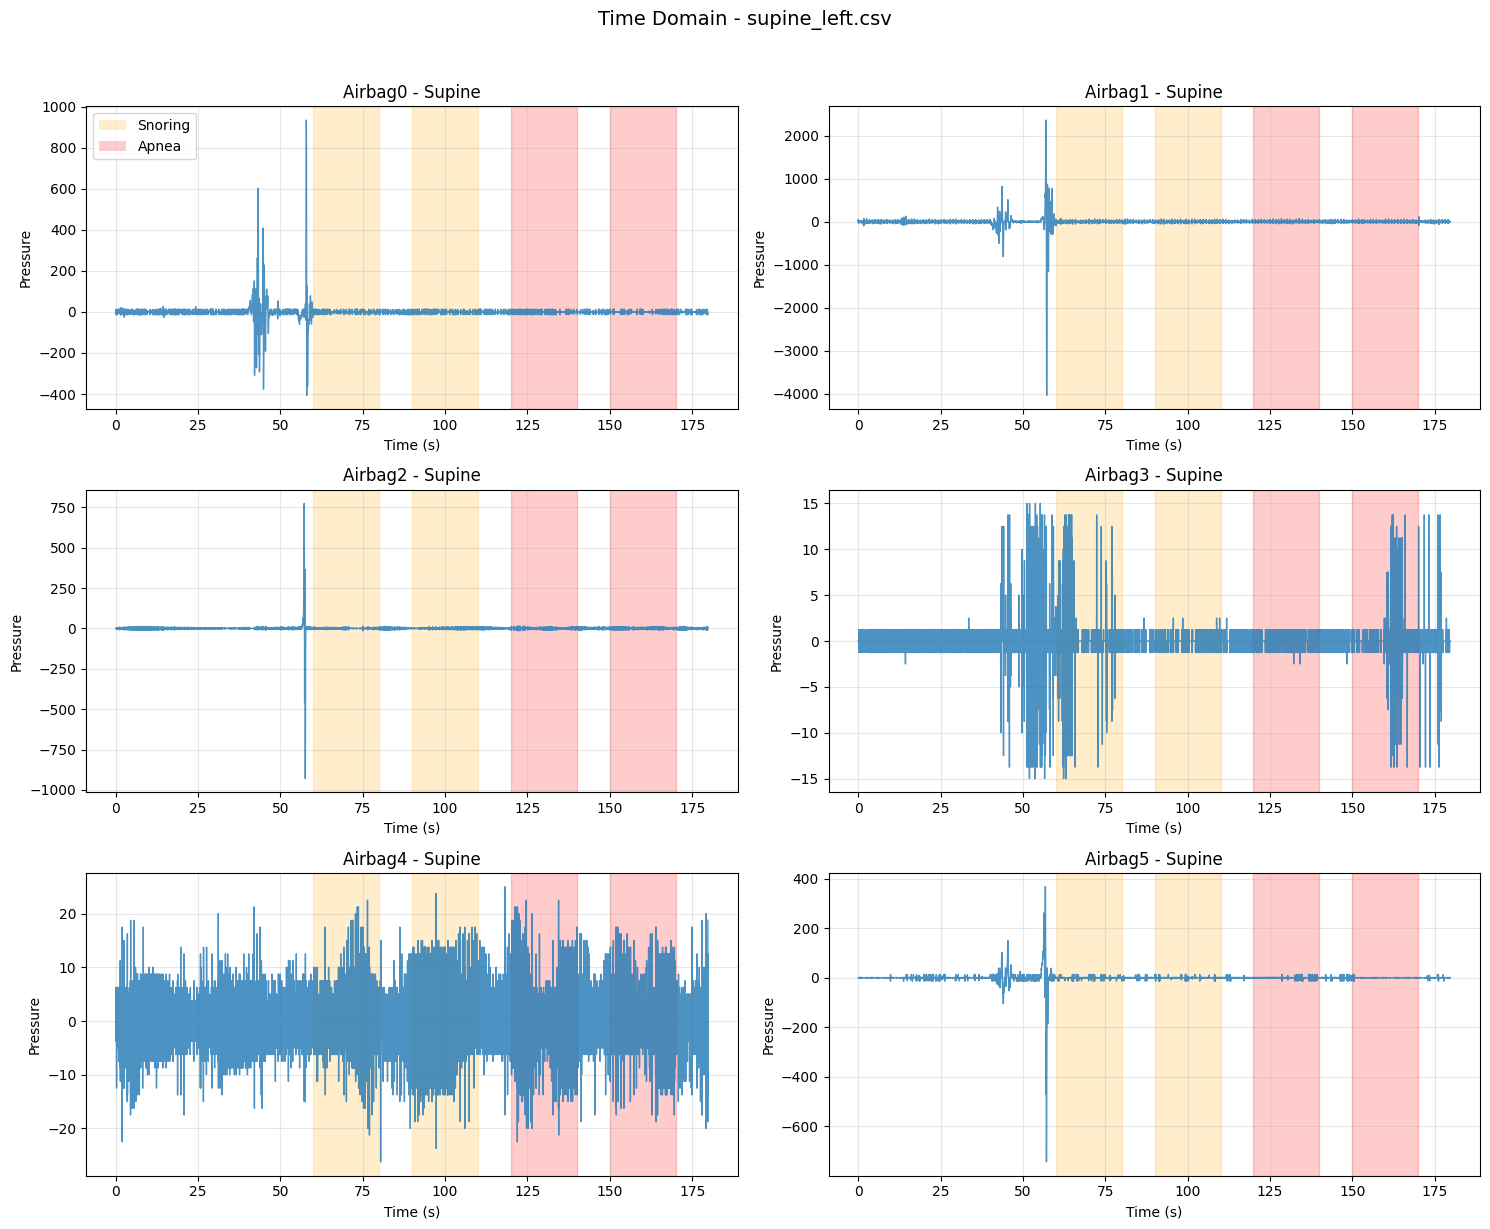

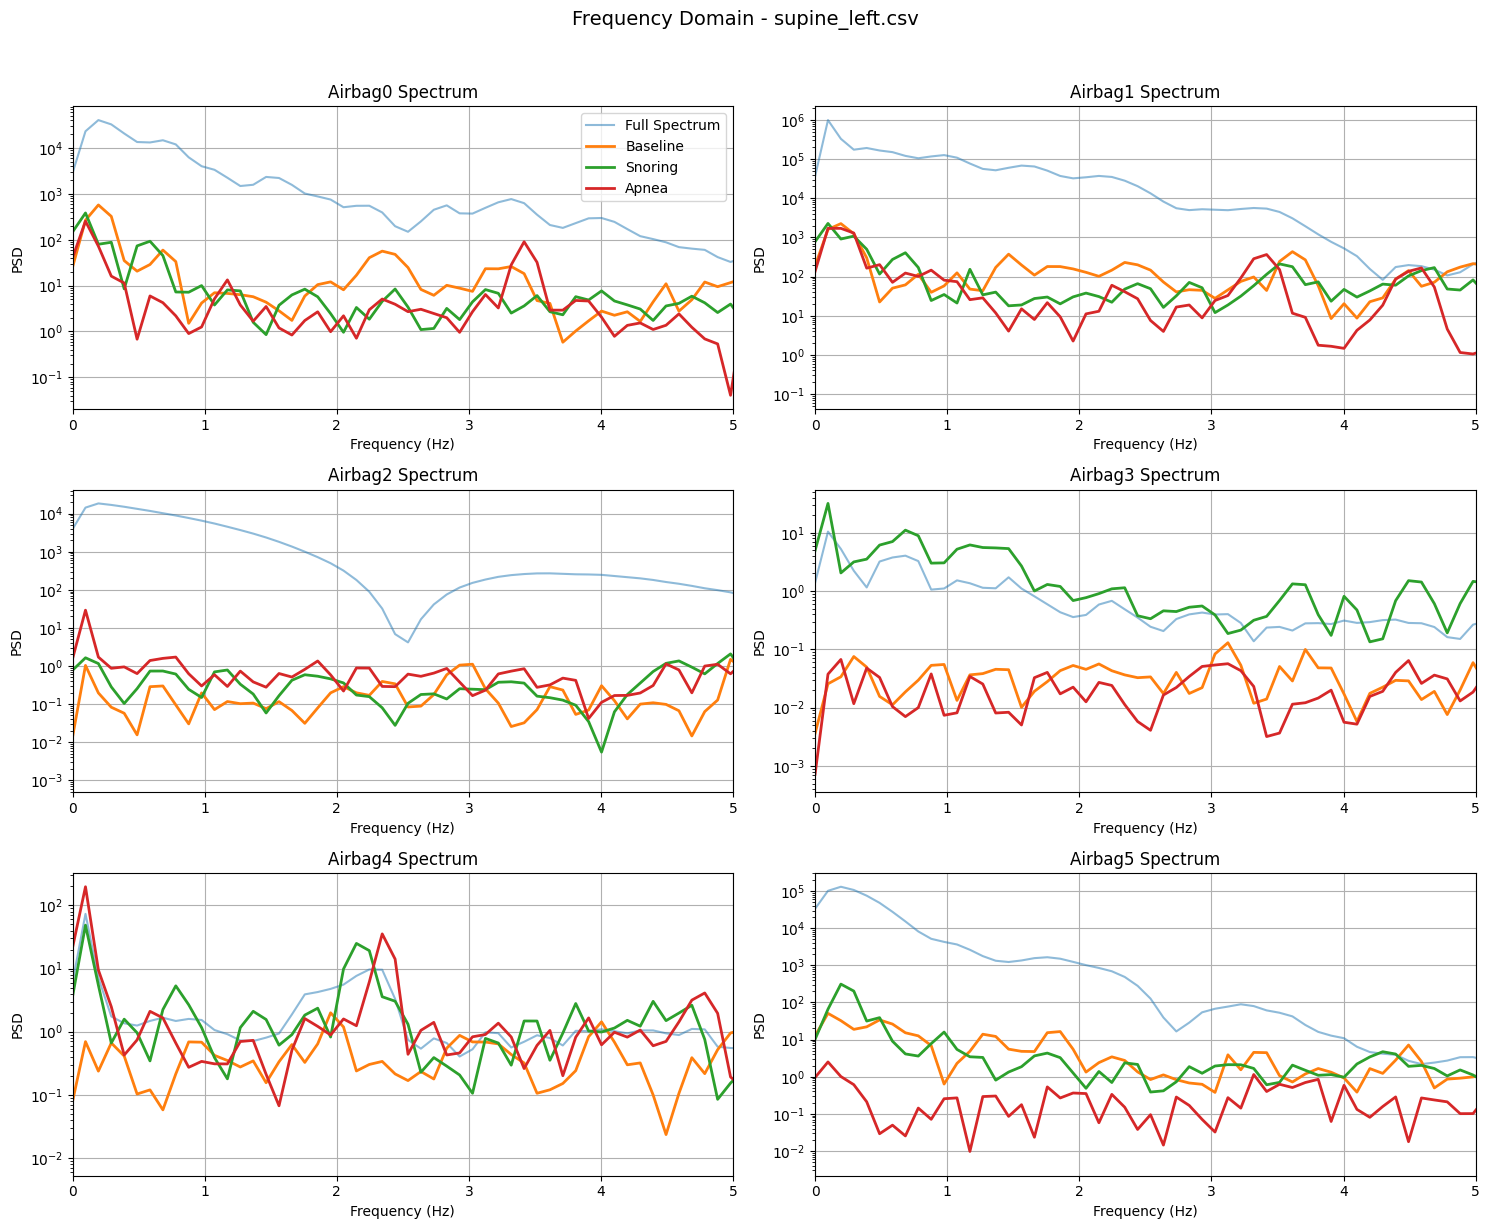

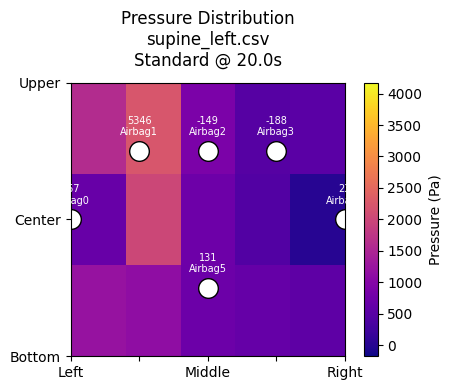

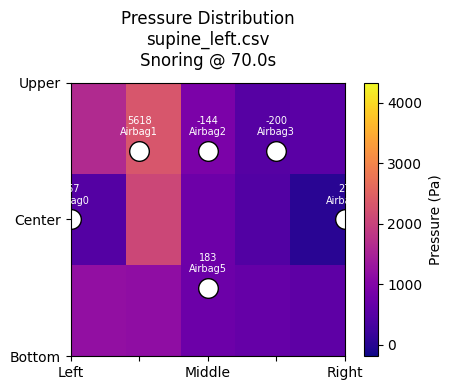

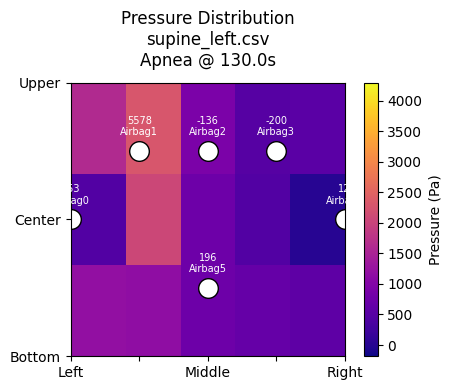

Processing supine_middle.csv...


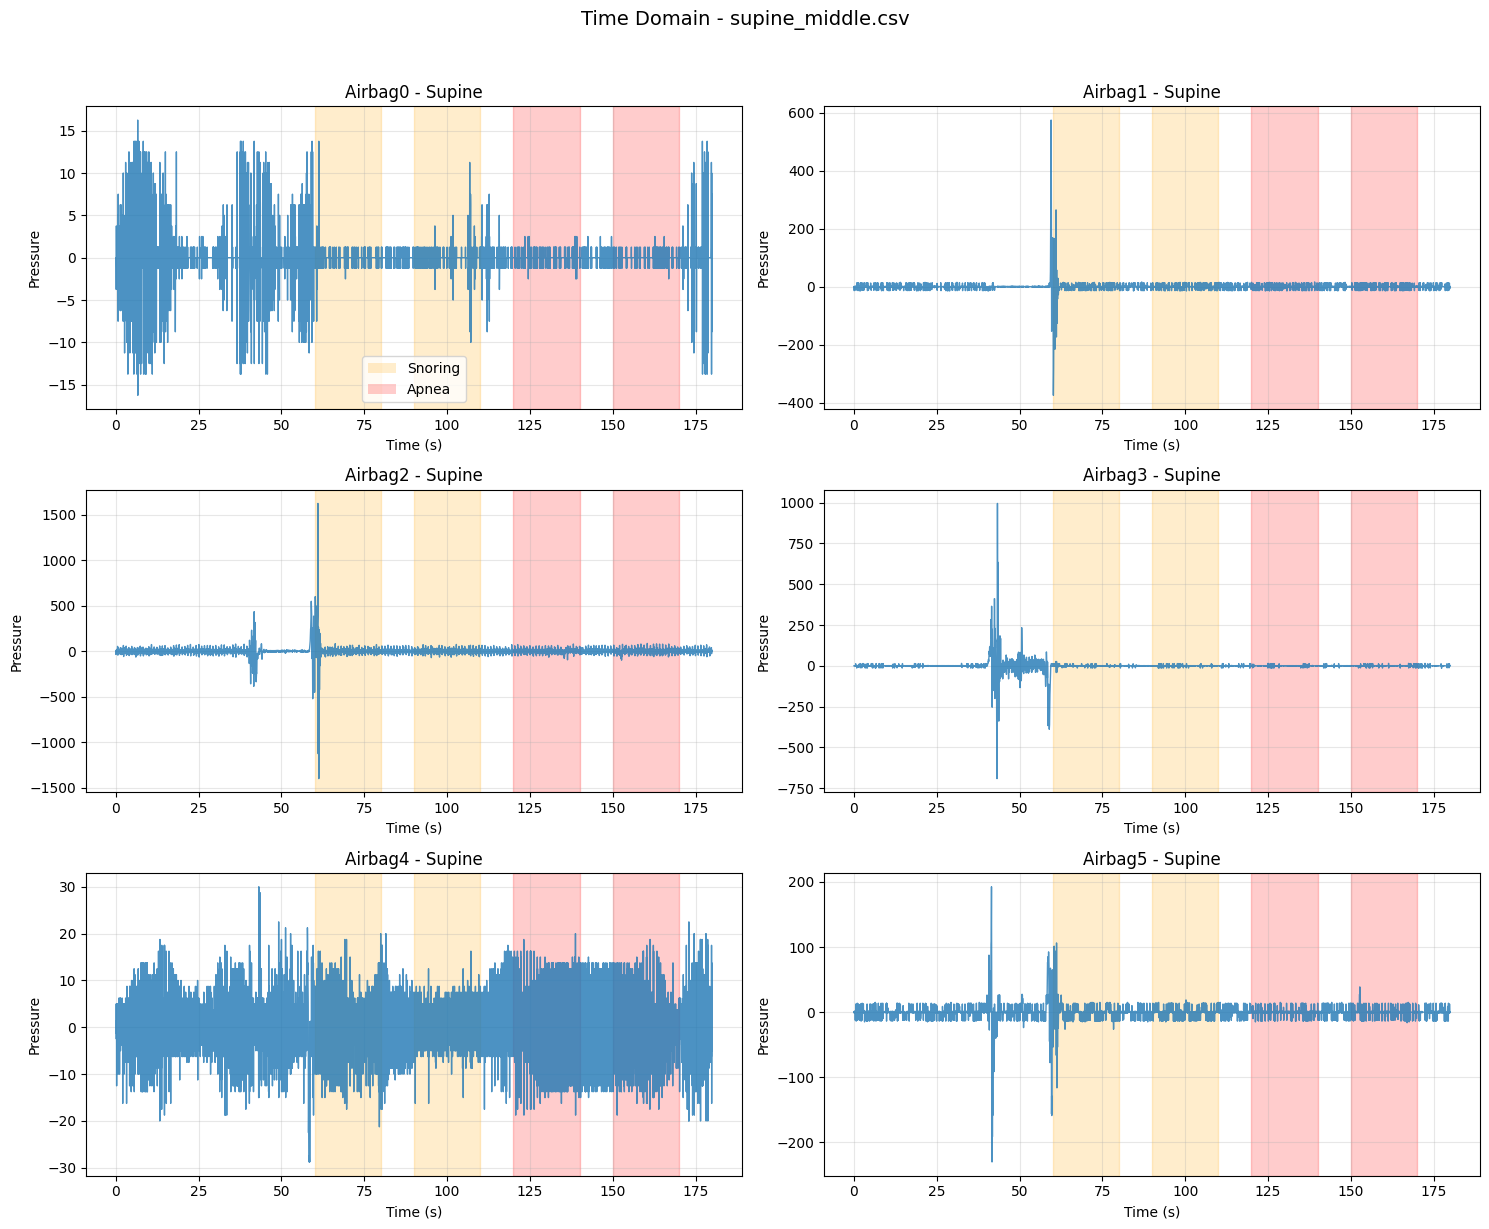

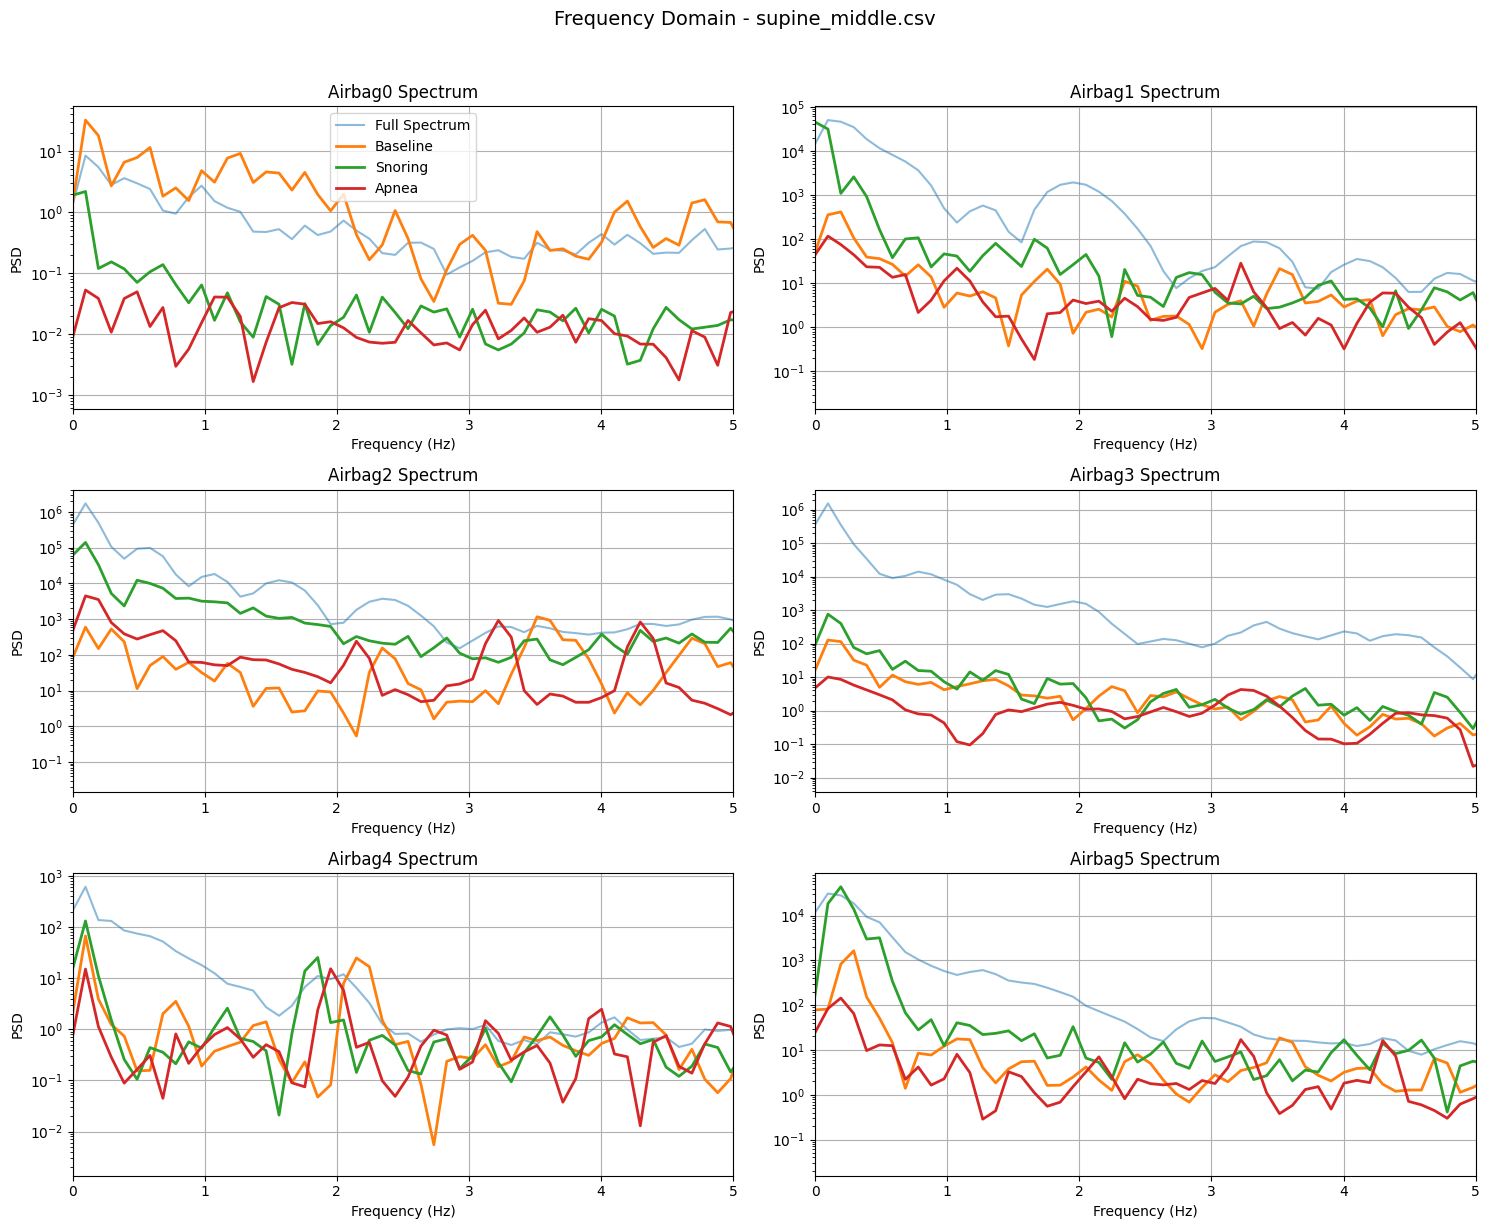

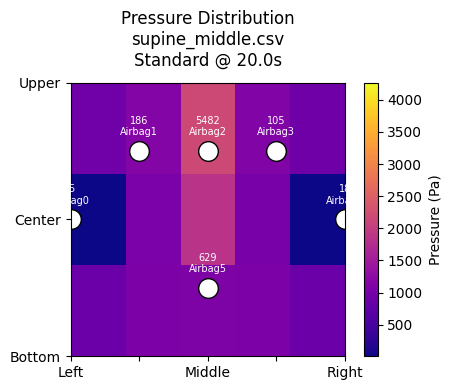

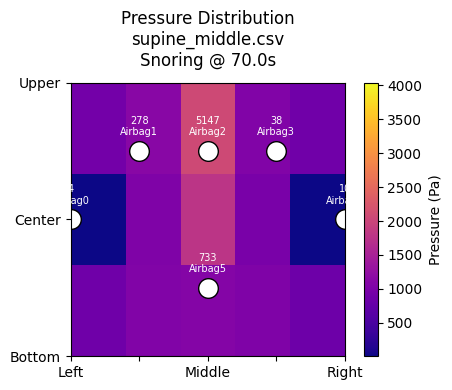

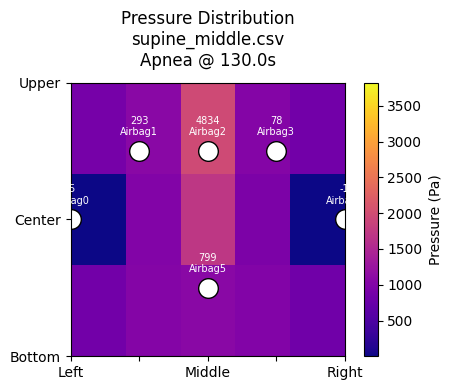

Processing supine_right.csv...


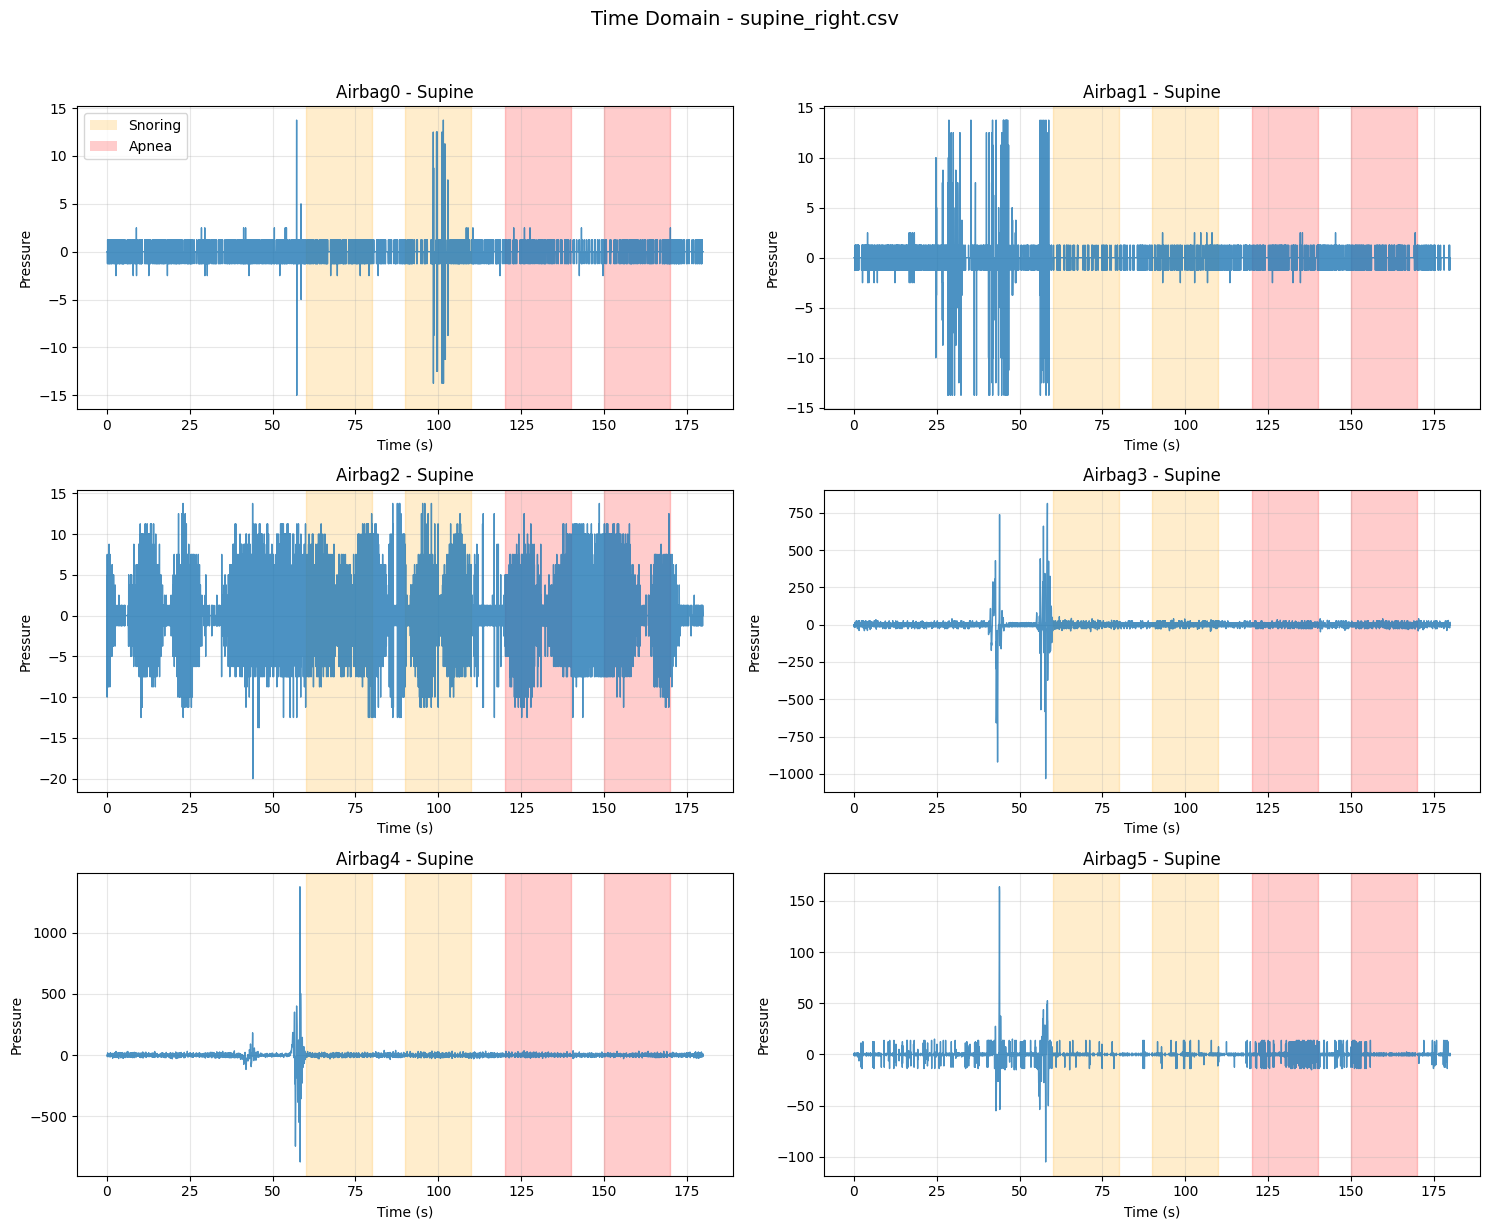

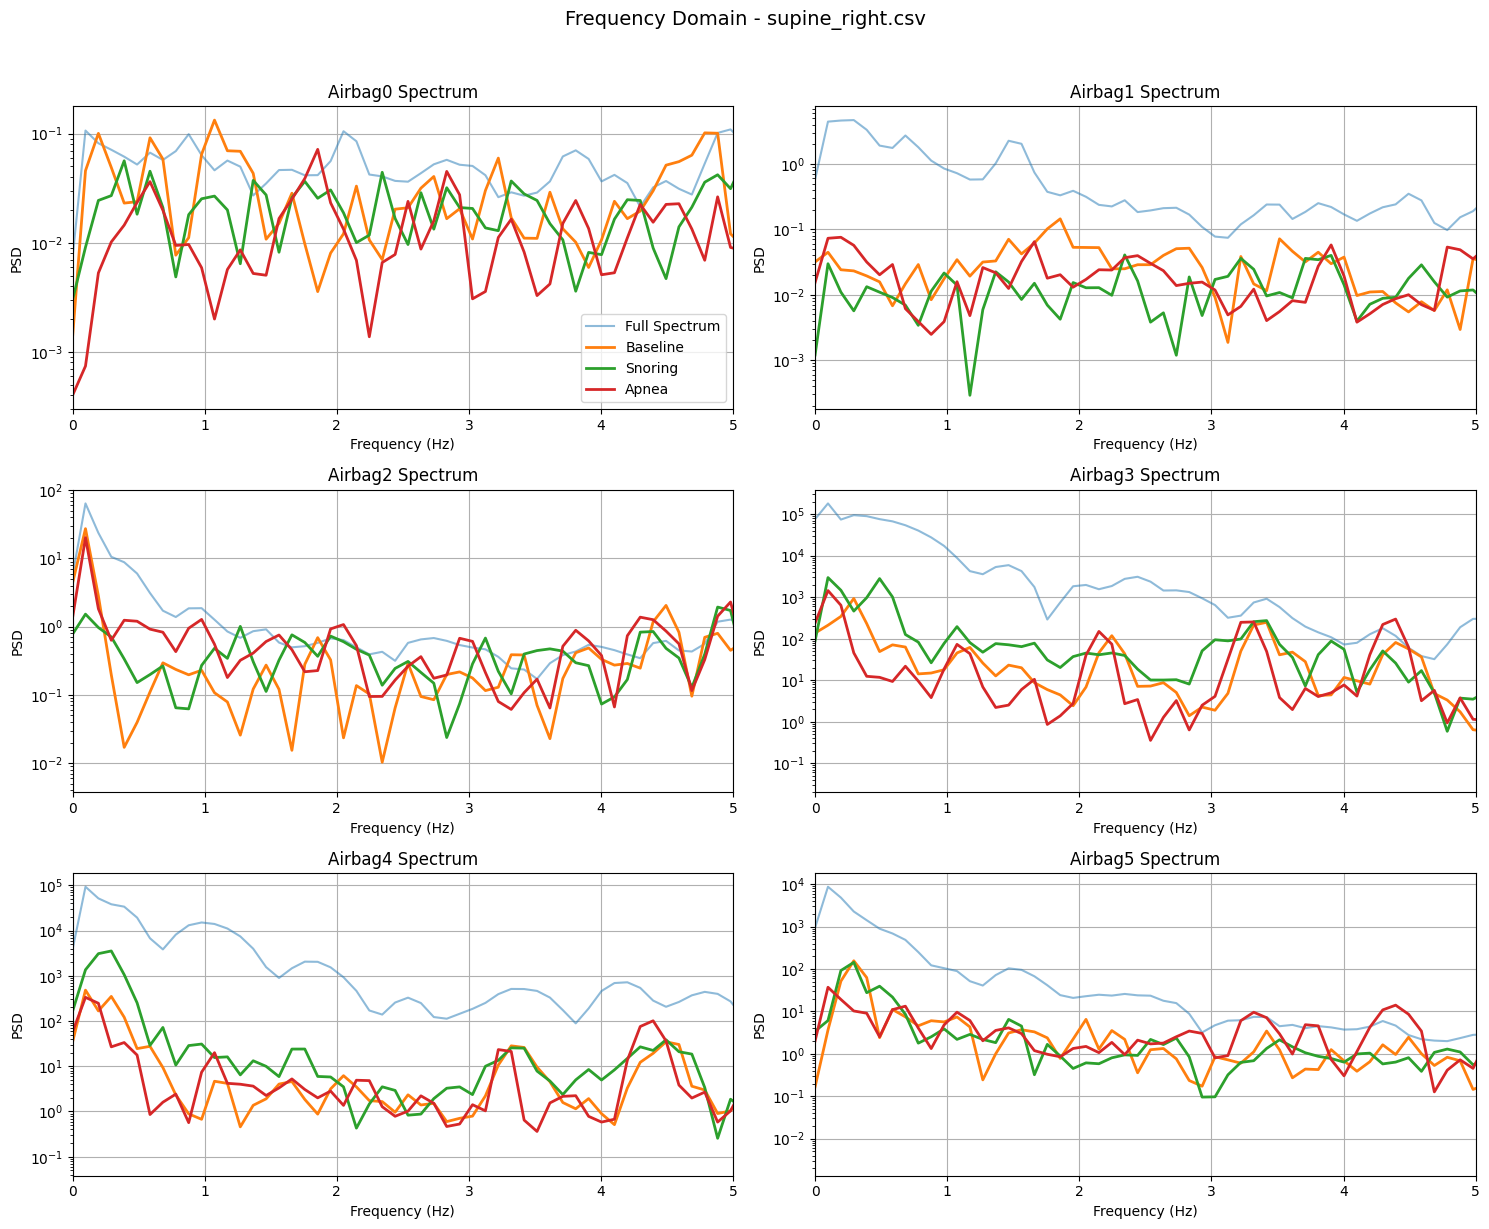

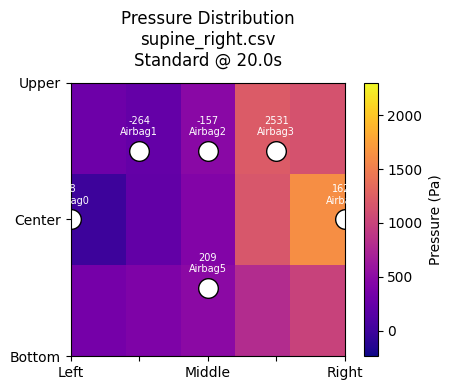

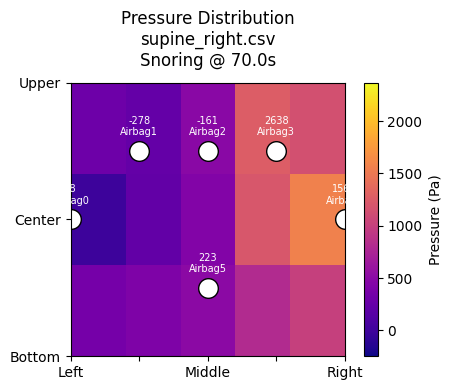

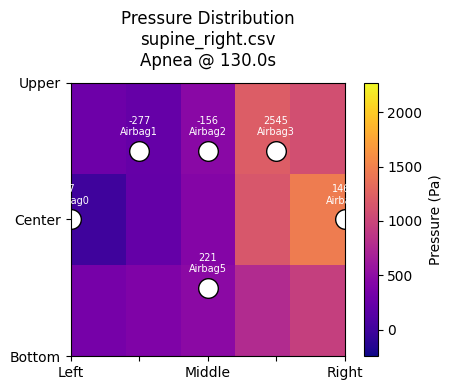

In [12]:
import pandas as pd
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf, griddata
from scipy.signal import spectrogram

data_dir = r'C:\Users\yangk\Desktop\fortest\raw_data'
output_dir = r'C:\Users\yangk\Desktop\fortest\output'
AIRBAG_COLS = ['Airbag0', 'Airbag1', 'Airbag2', 'Airbag3', 'Airbag4', 'Airbag5']
sampling_rate = 25

def load_baseline():
    try:
        baseline_df = pd.read_csv(os.path.join(data_dir, 'pillow_initial_state.csv'))
        return baseline_df[AIRBAG_COLS].mean()
    except Exception as e:
        print(f"Failed to load baseline data: {str(e)}")
        return pd.Series([0]*6, index=AIRBAG_COLS)

def label_data(file_path):
    
    df = pd.read_csv(file_path)
    
    filename = os.path.basename(file_path).lower()
    if 'prone' in filename:
        posture = 'prone'
    elif 'lateral' in filename:
        posture = 'lateral'
    elif 'supine' in filename:
        posture = 'supine'
    df['Posture Type'] = posture
    
    total_samples = len(df)
    time_points = np.arange(total_samples) / sampling_rate
    
    df['Is snoring'] = 0
    df['Is apnea'] = 0
    
    for i, t in enumerate(time_points):
        if (60 <= t < 80) or (90 <= t < 110):
            df.at[i, 'Is snoring'] = 1
        
        if (120 <= t < 140) or (150 <= t < 170):
            df.at[i, 'Is apnea'] = 1
    
   # baseline calibration
    BASELINE = load_baseline()
    calibrated_df = df.copy()
    calibrated_df[AIRBAG_COLS] = df[AIRBAG_COLS] - BASELINE.values

    # 1-DIFF
    diff_df = df.copy()
    diff_df[AIRBAG_COLS] = df[AIRBAG_COLS].diff().fillna(0)

    # visualization
    plot_time_domain(diff_df, filename, time_points)
    frequency_analysis(calibrated_df, filename, time_points)
    analyze_key_periods(calibrated_df, filename)
    
    return df

def plot_time_domain(df, filename, time_points):
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"Time Domain - {filename}", fontsize=14, y=1.02)

    event_zones = {
        'snoring': [(60,80), (90,110)],
        'apnea': [(120,140), (150,170)]
    }

    for idx, airbag in enumerate(AIRBAG_COLS, 1):
        ax = plt.subplot(3, 2, idx)
        ax.plot(time_points, df[airbag], linewidth=1, alpha=0.8)
        
        for zone in event_zones['snoring']:
            ax.axvspan(zone[0], zone[1], color='orange', alpha=0.2)
        for zone in event_zones['apnea']:
            ax.axvspan(zone[0], zone[1], color='red', alpha=0.2)
        
        ax.set_title(f"{airbag} - {df['Posture Type'].iloc[0].capitalize()}")
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Pressure')
        ax.grid(True, alpha=0.3)
        
        if idx == 1:
            legend_elements = [
                plt.Rectangle((0,0),1,1,fc='orange', alpha=0.2, label='Snoring'),
                plt.Rectangle((0,0),1,1,fc='red', alpha=0.2, label='Apnea')
            ]
            ax.legend(handles=legend_elements)

    plt.tight_layout()
    plt.show()

def frequency_analysis(df, filename, time_points):

    plt.figure(figsize=(15, 12))
    plt.suptitle(f"Frequency Domain - {filename}", fontsize=14, y=1.02)
    
    segments = [
        ('Baseline', (10, 30)),
        ('Snoring', (60, 80)),
        ('Apnea', (120, 140))
    ]
    
    for idx, airbag in enumerate(AIRBAG_COLS, 1):
        ax = plt.subplot(3, 2, idx)
        data = df[airbag].values
        
        f, Pxx = signal.welch(data, fs=sampling_rate, nperseg=256)
        ax.semilogy(f, Pxx, label='Full Spectrum', alpha=0.5)
        
        for seg_name, (start, end) in segments:
            seg_data = df[(time_points >= start) & (time_points < end)][airbag]
            f_seg, Pxx_seg = signal.welch(seg_data, fs=sampling_rate, nperseg=256)
            ax.semilogy(f_seg, Pxx_seg, label=seg_name, lw=2)
        
        ax.set_title(f"{airbag} Spectrum")
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('PSD')
        ax.set_xlim(0, 5)
        ax.grid(True)
        if idx == 1:
            ax.legend()

    plt.tight_layout()
    plt.show()


# Sensor layout configuration
SENSOR_LAYOUT = {
    0: (0, 1),    # Airbag0
    1: (1, 1.5),  # Airbag1
    2: (2, 1.5),  # Airbag2
    3: (3, 1.5),  # Airbag3
    4: (4, 1),    # Airbag4
    5: (2, 0.5)   # Airbag5
}

# generate 5x3 grid
GRID_X, GRID_Y = np.mgrid[0:4:5j, 0:2:3j]

VIRTUAL_POINTS = [
    (0,0), (1,0), (2,0), (3,0), (4,0),  # lower bound
    (0,2), (1,2), (2,2), (3,2), (4,2),  # upper bound
    (0,0.5), (0,1),                     
    (4,0.5), (4,1),                     
    (1,1), (3,1),                       
    (2,1)                               
]

def enhanced_interpolation(values):
    real_points = np.array(list(SENSOR_LAYOUT.values()))
    all_points = np.vstack([real_points, VIRTUAL_POINTS])
    
    virtual_values = []
    for (x,y) in VIRTUAL_POINTS:
        sym_weights = []
        for px, py in real_points:
            dx = abs(px - x)
            dy = abs(py - y)
            distance = np.sqrt(dx**2 + dy**2)
            weight = 1 / (distance + 1e-6)
            sym_weights.append(weight)
        
        sym_weights = np.array(sym_weights)
        sym_weights /= sym_weights.sum()
        
        virtual_values.append(np.dot(values, sym_weights))
    
    all_values = np.concatenate([values, virtual_values])
    
    # Interpolate using cubic splines
    grid = griddata(all_points, all_values, (GRID_X, GRID_Y),
                   method='cubic', fill_value=0)
    
    # print(grid.T)
    return np.nan_to_num(grid.T)

def generate_heatmap(values, title):
    plt.figure(figsize=(10, 4))
    
    grid = enhanced_interpolation(values)
    
    im = plt.imshow(grid, origin='lower', cmap='plasma',
                  extent=[0,4,0,2], aspect=2,
                  vmin=np.percentile(values, 5),
                  vmax=np.percentile(values, 95))
    
    sensor_labels = {
        0: "Airbag0",
        1: "Airbag1",
        2: "Airbag2",
        3: "Airbag3",
        4: "Airbag4",
        5: "Airbag5"
    }
    for i, (x, y) in SENSOR_LAYOUT.items():
        plt.scatter(x, y, c='w', s=200, edgecolors='k', linewidth=1)
        plt.text(x, y+0.1, f'{values[i]:.0f}\n{sensor_labels[i]}',
                ha='center', va='bottom', color='w', fontsize=7)
    
    
    plt.colorbar(im, label='Pressure (Pa)', pad=0.02)
    plt.title(f"Pressure Distribution\n{title}", pad=12)
    plt.xticks([0,1,2,3,4], ['Left', '', 'Middle', '', 'Right'])
    plt.yticks([0, 1, 2], ['Bottom', 'Center', 'Upper'])
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def analyze_key_periods(df, filename):
    """关键时段分析"""
    analysis_points = {
        'Standard': 20 * sampling_rate, 
        # 'Movement': 50 * sampling_rate,
        'Snoring': 70 * sampling_rate, 
        'Apnea': 130 * sampling_rate
    }
    
    for name, idx in analysis_points.items():
        if idx >= len(df):
            print(f"skip {name} - Insufficient data length")
            continue
        
        values = df[AIRBAG_COLS].iloc[idx].values
        generate_heatmap(values, f"{filename}\n{name} @ {idx/sampling_rate:.1f}s")

# Main
for file in os.listdir(data_dir):
    if file.endswith('.csv') and 'initial_state' not in file:
        print(f"Processing {file}...")
        label_data(os.path.join(data_dir, file))

# STEP 2: Hybrid Model Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


AIRBAG_COLS = ['Airbag0', 'Airbag1', 'Airbag2', 'Airbag3', 'Airbag4', 'Airbag5']
data_dir = r'C:\Users\yangk\Desktop\fortest\raw_data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 50
SPATIAL_SHAPE = (3, 5)

def process_data(file_path):
    df = label_data(file_path)  # get the DataFrame with the label
    
    # baseline subtraction
    baseline = load_baseline()
    calibrated_df = df.copy()
    calibrated_df[AIRBAG_COLS] = df[AIRBAG_COLS] - baseline.values
    
    # 1-diff
    diff_df = df.copy()
    diff_df[AIRBAG_COLS] = df[AIRBAG_COLS].diff().fillna(0)
    
    X_temporal, X_spatial, y_posture, y_apnea, y_snoring = [], [], [], [], []
    
    for i in range(0, len(diff_df)-SEQ_LENGTH, SEQ_LENGTH//2):
        # temporal input
        temporal = diff_df.iloc[i:i+SEQ_LENGTH][AIRBAG_COLS].values.astype(np.float32)
        
        # spatial input
        last_values = calibrated_df.iloc[i+SEQ_LENGTH-1][AIRBAG_COLS].values.astype(np.float32)
        grid = enhanced_interpolation(last_values).astype(np.float32)
        
        # Label (state of last frame)
        y_posture.append(df.iloc[i+SEQ_LENGTH-1]['Posture Type'])
        y_apnea.append(df.iloc[i+SEQ_LENGTH-1]['Is apnea'])
        y_snoring.append(df.iloc[i+SEQ_LENGTH-1]['Is snoring'])
        
        X_temporal.append(temporal)
        X_spatial.append(grid)
    
    return np.array(X_temporal), np.array(X_spatial), y_posture, np.array(y_apnea), np.array(y_snoring)

class SleepDataset(Dataset):
    def __init__(self, temporal, spatial, posture, apnea, snoring):
        self.temporal = torch.FloatTensor(temporal)
        self.spatial = torch.FloatTensor(spatial)
        self.posture = torch.LongTensor(posture)
        self.apnea = torch.FloatTensor(apnea)
        self.snoring = torch.FloatTensor(snoring)
        
    def __len__(self):
        return len(self.temporal)
    
    def __getitem__(self, idx):
        return (self.temporal[idx], self.spatial[idx]), (self.posture[idx], self.apnea[idx], self.snoring[idx])

class HybridModel(nn.Module):
    def __init__(self, num_postures):
        super().__init__()
        
        # Temporal Encoder (Transformer)
        self.temporal_proj = nn.Linear(6, 64)
        encoder_layer = TransformerEncoderLayer(
            d_model=64,
            nhead=4,
            dim_feedforward=256,
            dropout=0.1
        )
        self.temporal_transformer = TransformerEncoder(encoder_layer, num_layers=3)
        self.temporal_pool = nn.AdaptiveAvgPool1d(1)
        
        # Spatial Encoder (CNN)
        self.spatial_encoder = nn.Sequential(
            nn.Conv2d(1, 16, 2, padding=1),    # [B, 1, 3,5] -> [B,16,3,5]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # -> [B,16,1,2]
            nn.Conv2d(16, 32, 2, padding=1),   # -> [B,32,1,2]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),       # -> [B,32,1,1]
            nn.Flatten()                       # -> [B,32]
        )
        self.spatial_proj = nn.Linear(32, 64)  # -> [B,64]
        
        # Cross Attention
        self.cross_attn = nn.MultiheadAttention(embed_dim=64, num_heads=4)
        
        # Classification Heads
        self.posture_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_postures)
        )
        self.apnea_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.snoring_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, temporal, spatial):
        # Temporal processing [B, T, F] -> [B, D]
        temporal = temporal.permute(1, 0, 2)  # [T, B, 6]
        temporal = self.temporal_proj(temporal)  # [T, B, 64]
        temporal = self.temporal_transformer(temporal)  # [T, B, 64]
        
        temporal = temporal.permute(1, 2, 0)  # [B, 64, T]
        temporal = self.temporal_pool(temporal)  # [B, 64, 1]
        temporal = temporal.squeeze(-1)  # [B, 64]
        
        # Spatial processing [B, H, W] -> [B, D]
        spatial = spatial.unsqueeze(1)  # [B,1,3,5]
        spatial = self.spatial_encoder(spatial)  # [B,32]
        spatial = self.spatial_proj(spatial)  # [B,64]
        
        # Cross Attention (spatial input as query)
        query = spatial.unsqueeze(0)  # [1, B, 64]
        key = temporal.unsqueeze(0)   # [1, B, 64]
        value = temporal.unsqueeze(0) # [1, B, 64]
        
        attn_out, _ = self.cross_attn(query, key, value)
        features = attn_out.squeeze(0)  # [B, 64]
        
        # Multi-task prediction
        posture = self.posture_head(features)
        apnea = self.apnea_head(features)
        snoring = self.snoring_head(features)
        
        return posture, apnea.squeeze(), snoring.squeeze()

def train_hybrid():
    all_temporal, all_spatial, all_posture, all_apnea, all_snoring = [], [], [], [], []
    for file in os.listdir(data_dir):
        if file.endswith('.csv') and 'initial' not in file:
            t, s, p, a, sn = process_data(os.path.join(data_dir, file))
            all_temporal.append(t)
            all_spatial.append(s)
            all_posture.extend(p)
            all_apnea.append(a)
            all_snoring.append(sn)
    
    X_temporal = np.concatenate(all_temporal)
    X_spatial = np.concatenate(all_spatial)
    y_posture = np.array(all_posture)
    y_apnea = np.concatenate(all_apnea)
    y_snoring = np.concatenate(all_snoring)
    
    # encode pose labels
    le = LabelEncoder()
    y_posture = le.fit_transform(y_posture)
    
    (X_temp_train, X_temp_test, 
     X_spa_train, X_spa_test,
     y_post_train, y_post_test,
     y_apn_train, y_apn_test,
     y_sno_train, y_sno_test) = train_test_split(
        X_temporal, X_spatial, y_posture, y_apnea, y_snoring,
        test_size=0.2, random_state=42
    )
    
    train_dataset = SleepDataset(X_temp_train, X_spa_train, y_post_train, y_apn_train, y_sno_train)
    test_dataset = SleepDataset(X_temp_test, X_spa_test, y_post_test, y_apn_test, y_sno_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    model = HybridModel(num_postures=len(le.classes_)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    
    # loss function
    criterion_post = nn.CrossEntropyLoss()
    criterion_task = nn.BCEWithLogitsLoss()
    
    for epoch in range(50):
        model.train()
        total_loss = 0
        for (temporal, spatial), (posture, apnea, snoring) in train_loader:
            temporal = temporal.to(device)
            spatial = spatial.to(device)
            posture = posture.to(device)
            apnea = apnea.to(device)
            snoring = snoring.to(device)
            
            optimizer.zero_grad()
            
            post_pred, apn_pred, sno_pred = model(temporal, spatial)
            loss_post = criterion_post(post_pred, posture)
            loss_apn = criterion_task(apn_pred, apnea)
            loss_sno = criterion_task(sno_pred, snoring)
            loss = loss_post + loss_apn + loss_sno
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        correct_post, correct_apn, correct_sno = 0, 0, 0
        total = 0
        with torch.no_grad():
            for (temporal, spatial), (posture, apnea, snoring) in test_loader:
                temporal = temporal.to(device)
                spatial = spatial.to(device)
                
                post_pred, apn_pred, sno_pred = model(temporal, spatial)
                
                _, post_pred = torch.max(post_pred, 1)
                apn_pred = torch.sigmoid(apn_pred) > 0.5
                sno_pred = torch.sigmoid(sno_pred) > 0.5
                
                correct_post += (post_pred.cpu() == posture).sum().item()
                correct_apn += (apn_pred.cpu() == apnea).sum().item()
                correct_sno += (sno_pred.cpu() == snoring).sum().item()
                total += posture.size(0)
        
        val_post = 100 * correct_post / total
        val_apn = 100 * correct_apn / total
        val_sno = 100 * correct_sno / total
        print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f}")
        print(f"Posture Acc: {val_post:.1f}% | Apnea Acc: {val_apn:.1f}% | Snore Acc: {val_sno:.1f}%")
    return model

if __name__ == "__main__":
    model = train_hybrid()

c:\Users\yangk\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01 | Loss: 2.2357
Posture Acc: 31.8% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 02 | Loss: 2.1357
Posture Acc: 51.7% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 03 | Loss: 1.9402
Posture Acc: 66.4% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 04 | Loss: 1.7539
Posture Acc: 68.8% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 05 | Loss: 1.5229
Posture Acc: 76.0% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 06 | Loss: 1.4576
Posture Acc: 79.1% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 07 | Loss: 1.4450
Posture Acc: 82.2% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 08 | Loss: 1.3866
Posture Acc: 78.8% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 09 | Loss: 1.3549
Posture Acc: 81.9% | Apnea Acc: 77.6% | Snore Acc: 73.8%
Epoch 10 | Loss: 1.3557
Posture Acc: 81.3% | Apnea Acc: 77.9% | Snore Acc: 74.5%
Epoch 11 | Loss: 1.2739
Posture Acc: 81.9% | Apnea Acc: 77.9% | Snore Acc: 74.5%
Epoch 12 | Loss: 1.2591
Posture Acc: 81.3% | Apnea Acc: 79.4% | Snore Acc: 75.1%
Epoch 13 | Loss: 1.3543
Post

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

AIRBAG_COLS = ['Airbag0', 'Airbag1', 'Airbag2', 'Airbag3', 'Airbag4', 'Airbag5']
data_dir = r'C:\Users\yangk\Desktop\fortest\raw_data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 50

# LSTM
class LSTMModel(nn.Module):
    def __init__(self, num_postures, input_size=6, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.posture_head = nn.Sequential(
            nn.Linear(hidden_size*2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_postures)
        )
        self.apnea_head = nn.Sequential(
            nn.Linear(hidden_size*2, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
        self.snoring_head = nn.Sequential(
            nn.Linear(hidden_size*2, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last_out = out[:, -1, :]
        return (self.posture_head(last_out), 
                self.apnea_head(last_out).squeeze(),
                self.snoring_head(last_out).squeeze())

def prepare_data():
    all_temporal, all_spatial, all_posture, all_apnea, all_snoring = [], [], [], [], []
    for file in os.listdir(data_dir):
        if file.endswith('.csv') and 'initial' not in file:
            t, s, p, a, sn = process_data(os.path.join(data_dir, file))
            all_temporal.append(t)
            all_spatial.append(s)
            all_posture.extend(p)
            all_apnea.append(a)
            all_snoring.append(sn)
    
    X_temporal = np.concatenate(all_temporal)
    y_posture = LabelEncoder().fit_transform(all_posture)
    return (X_temporal, 
            np.concatenate(all_apnea),
            np.concatenate(all_snoring),
            y_posture)

def train_lstm():
    X_temporal, y_apnea, y_snoring, y_posture = prepare_data()
    
    (X_train, X_test, 
     y_post_train, y_post_test,
     y_apn_train, y_apn_test,
     y_sno_train, y_sno_test) = train_test_split(
        X_temporal, y_posture, y_apnea, y_snoring,
        test_size=0.2, 
        random_state=42,
        stratify=y_posture
    )

    class LSTMDataset(Dataset):
        def __init__(self, temporal, posture, apnea, snoring):
            self.temporal = torch.FloatTensor(temporal)
            self.posture = torch.LongTensor(posture)
            self.apnea = torch.FloatTensor(apnea)
            self.snoring = torch.FloatTensor(snoring)
        
        def __len__(self): return len(self.temporal)
        
        def __getitem__(self, idx):
            return (self.temporal[idx], 
                    (self.posture[idx], self.apnea[idx], self.snoring[idx]))

    train_loader = DataLoader(
        LSTMDataset(X_train, y_post_train, y_apn_train, y_sno_train),
        batch_size=64, 
        shuffle=True,
        pin_memory=True
    )
    test_loader = DataLoader(
        LSTMDataset(X_test, y_post_test, y_apn_test, y_sno_test),
        batch_size=128,
        pin_memory=True
    )

    model = LSTMModel(num_postures=len(np.unique(y_posture))).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion_post = nn.CrossEntropyLoss()
    criterion_task = nn.BCEWithLogitsLoss()

    best_acc = 0
    for epoch in range(30):
        model.train()
        total_loss = 0
        for batch in train_loader:
            temporal, (posture, apnea, snoring) = batch
            temporal = temporal.to(device, non_blocking=True)
            posture = posture.to(device, non_blocking=True)
            apnea = apnea.to(device, non_blocking=True)
            snoring = snoring.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            post_pred, apn_pred, sno_pred = model(temporal)
            
            loss = (criterion_post(post_pred, posture) +
                    criterion_task(apn_pred, apnea) +
                    criterion_task(sno_pred, snoring))
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        # 验证逻辑
        model.eval()
        post_correct = apn_correct = sno_correct = 0
        total = 0
        with torch.no_grad():
            for temporal, (posture, apnea, snoring) in test_loader:
                temporal = temporal.to(device, non_blocking=True)
                posture = posture.to(device, non_blocking=True)
                apnea = apnea.to(device, non_blocking=True)
                snoring = snoring.to(device, non_blocking=True)
                
                post_pred, apn_pred, sno_pred = model(temporal)
                
                post_correct += (post_pred.argmax(1) == posture).sum().item()
                apn_correct += ((torch.sigmoid(apn_pred) > 0.5) == apnea.bool()).sum().item()
                sno_correct += ((torch.sigmoid(sno_pred) > 0.5) == snoring.bool()).sum().item()
                total += posture.size(0)
        
        val_post = 100 * post_correct / total
        val_apn = 100 * apn_correct / total
        val_sno = 100 * sno_correct / total
        print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f}")
        print(f"Posture: {val_post:.1f}% | Apnea: {val_apn:.1f}% | Snore: {val_sno:.1f}%")
        
        if val_post > best_acc:
            best_acc = val_post
            torch.save(model.state_dict(), "best_lstm.pth")
    
    print(f"\nLSTM Best Posture Accuracy: {best_acc:.1f}%")
    return model

# SVM
def train_svm():
    X_temporal, y_apnea, y_snoring, y_posture = prepare_data()
    
    X_flat = X_temporal.reshape(len(X_temporal), -1)  # (N, 50*6=300)
    
    (X_train, X_test,
     y_post_train, y_post_test,
     y_apn_train, y_apn_test,
     y_sno_train, y_sno_test) = train_test_split(
        X_flat, y_posture, y_apnea, y_snoring,
        test_size=0.2,
        random_state=42,
        stratify=y_posture
    )

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # posture classifier
    svm_post = SVC(
        C=1.5, 
        kernel='rbf',
        class_weight='balanced',
        decision_function_shape='ovr'
    )
    svm_post.fit(X_train, y_post_train)
    post_acc = 100 * accuracy_score(y_post_test, svm_post.predict(X_test))

    # apnea classifier
    svm_apn = SVC(
        C=1.2,
        kernel='sigmoid',
        class_weight={0:1, 1:5},
        probability=True
    )
    svm_apn.fit(X_train, y_apn_train)
    apn_proba = svm_apn.predict_proba(X_test)[:, 1]
    apn_acc = 100 * accuracy_score(y_apn_test, (apn_proba > 0.35).astype(int))

    # snoring classifier
    svm_sno = SVC(
        C=0.8,
        kernel='poly',
        degree=2,
        class_weight='balanced'
    )
    svm_sno.fit(X_train, y_sno_train)
    sno_acc = 100 * accuracy_score(y_sno_test, svm_sno.predict(X_test))

    print("\nSVM Performance:")
    print(f"Posture: {post_acc:.1f}% | Apnea: {apn_acc:.1f}% | Snore: {sno_acc:.1f}%")
    return (svm_post, svm_apn, svm_sno)

if __name__ == "__main__":
    print("=== Training LSTM ===")
    lstm_model = train_lstm()
    
    print("\n=== Training SVM ===")
    svm_models = train_svm()

=== Training LSTM ===
Epoch 01 | Loss: 2.2961
Posture: 35.5% | Apnea: 76.9% | Snore: 80.1%
Epoch 02 | Loss: 2.1156
Posture: 60.1% | Apnea: 76.9% | Snore: 80.1%
Epoch 03 | Loss: 1.7994
Posture: 69.5% | Apnea: 76.9% | Snore: 80.1%
Epoch 04 | Loss: 1.5827
Posture: 82.9% | Apnea: 76.9% | Snore: 80.1%
Epoch 05 | Loss: 1.3992
Posture: 82.2% | Apnea: 76.9% | Snore: 80.1%
Epoch 06 | Loss: 1.2827
Posture: 86.9% | Apnea: 76.9% | Snore: 81.6%
Epoch 07 | Loss: 1.1994
Posture: 87.9% | Apnea: 76.9% | Snore: 82.6%
Epoch 08 | Loss: 1.1061
Posture: 90.3% | Apnea: 76.9% | Snore: 83.5%
Epoch 09 | Loss: 0.9605
Posture: 86.9% | Apnea: 76.9% | Snore: 81.9%
Epoch 10 | Loss: 0.9067
Posture: 91.6% | Apnea: 77.6% | Snore: 84.4%
Epoch 11 | Loss: 0.8536
Posture: 91.6% | Apnea: 76.9% | Snore: 76.6%
Epoch 12 | Loss: 0.8742
Posture: 89.1% | Apnea: 77.3% | Snore: 79.8%
Epoch 13 | Loss: 0.6930
Posture: 92.5% | Apnea: 78.8% | Snore: 79.1%
Epoch 14 | Loss: 0.6892
Posture: 91.9% | Apnea: 80.7% | Snore: 85.4%
Epoch 15 | L

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Student model
class StudentModel(nn.Module):
    def __init__(self, num_postures):
        super().__init__()
        
        # Simpler temporal encoders
        self.temporal_encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, padding=1),  # [B,6,T] -> [B,32,T]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),                             # [B,32,T/2]
            nn.Conv1d(32, 64, kernel_size=3, padding=1), # [B,64,T/2]
            nn.AdaptiveAvgPool1d(1),                     # [B,64,1]
            nn.Flatten()                                 # [B,64]
        )
        
        # Simpler spatial encoders
        self.spatial_encoder = nn.Sequential(
            nn.Conv2d(1, 8, 2),           # [B,1,3,5] -> [B,8,2,4]
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),              # [B,8,1,2]
            nn.Flatten(),                 # [B,16]
            nn.Linear(16, 64)             # [B,64]
        )
        
        # Share feature layers
        self.shared_layer = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        # Output header (same structure as teacher)
        self.posture_head = nn.Linear(64, num_postures)
        self.apnea_head = nn.Sequential(
            nn.Linear(64, 1))
        self.snoring_head = nn.Sequential(
            nn.Linear(64, 1))

    def forward(self, temporal, spatial):
        # [B, T, F] -> [B,64]
        temporal = temporal.permute(0, 2, 1)  # [B,6,T]
        temporal_feat = self.temporal_encoder(temporal)
        
        #[ B,3,5] -> [B,64]
        spatial = spatial.unsqueeze(1)  # [B,1,3,5]
        spatial_feat = self.spatial_encoder(spatial)
        
        combined = torch.cat([temporal_feat, spatial_feat], dim=1)
        features = self.shared_layer(combined)
        
        posture = self.posture_head(features)
        apnea = self.apnea_head(features).squeeze()
        snoring = self.snoring_head(features).squeeze()
        return posture, apnea, snoring

def distill_train(teacher_model):
    all_temporal, all_spatial, all_posture, all_apnea, all_snoring = [], [], [], [], []
    for file in os.listdir(data_dir):
        if file.endswith('.csv') and 'initial' not in file:
            t, s, p, a, sn = process_data(os.path.join(data_dir, file))
            all_temporal.append(t)
            all_spatial.append(s)
            all_posture.extend(p)
            all_apnea.append(a)
            all_snoring.append(sn)
    
    X_temporal = np.concatenate(all_temporal)
    X_spatial = np.concatenate(all_spatial)
    y_posture = np.array(all_posture)
    y_apnea = np.concatenate(all_apnea)
    y_snoring = np.concatenate(all_snoring)
    
    le = LabelEncoder()
    y_posture = le.fit_transform(y_posture)
    
    (X_temp_train, X_temp_test, 
     X_spa_train, X_spa_test,
     y_post_train, y_post_test,
     y_apn_train, y_apn_test,
     y_sno_train, y_sno_test) = train_test_split(
        X_temporal, X_spatial, y_posture, y_apnea, y_snoring,
        test_size=0.2, random_state=42
    )
    
    
    train_dataset = SleepDataset(X_temp_train, X_spa_train, y_post_train, y_apn_train, y_sno_train)
    test_dataset = SleepDataset(X_temp_test, X_spa_test, y_post_test, y_apn_test, y_sno_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    student = StudentModel(num_postures=len(le.classes_)).to(device)
    optimizer = optim.AdamW(student.parameters(), lr=1e-3)
    
    # loss function
    criterion_post = nn.CrossEntropyLoss()
    criterion_task = nn.BCEWithLogitsLoss()
    kl_loss = nn.KLDivLoss(reduction='batchmean')  # for classification distillation
    mse_loss = nn.MSELoss()  # for feature distillation
    
    temperature = 2.0
    alpha = 0.5        # raw loss weights
    beta = 0.3         # Output distillation weights
    gamma = 0.2        # Feature distillation weights
    
    for epoch in range(30):
        student.train()
        total_loss = 0
        for (temporal, spatial), (posture, apnea, snoring) in train_loader:
            temporal = temporal.to(device)
            spatial = spatial.to(device)
            posture = posture.to(device)
            apnea = apnea.to(device)
            snoring = snoring.to(device)
            
            with torch.no_grad():
                t_post, t_apn, t_sno = teacher_model(temporal, spatial)
                t_post_probs = torch.softmax(t_post / temperature, dim=-1)
            
            optimizer.zero_grad()
            s_post, s_apn, s_sno = student(temporal, spatial)
            
            # Original task loss
            loss_post = criterion_post(s_post, posture)
            loss_apn = criterion_task(s_apn, apnea)
            loss_sno = criterion_task(s_sno, snoring)
            original_loss = loss_post + loss_apn + loss_sno
            
            # Output distillation loss
            s_post_probs = torch.log_softmax(s_post / temperature, dim=-1)
            distill_post_loss = kl_loss(s_post_probs, t_post_probs) * (temperature**2)
            
            # Total loss
            total_loss = (alpha * original_loss + 
                         beta * distill_post_loss)
            
            total_loss.backward()
            optimizer.step()
            total_loss += total_loss.item()
        
        student.eval()
        correct_post, correct_apn, correct_sno = 0, 0, 0
        total = 0
        with torch.no_grad():
            for (temporal, spatial), (posture, apnea, snoring) in test_loader:
                temporal = temporal.to(device)
                spatial = spatial.to(device)
                
                post_pred, apn_pred, sno_pred = student(temporal, spatial)
                
                _, post_pred = torch.max(post_pred, 1)
                correct_post += (post_pred.cpu() == posture).sum().item()
                
                apn_pred = torch.sigmoid(apn_pred) > 0.5
                correct_apn += (apn_pred.cpu() == apnea).sum().item()
                
                sno_pred = torch.sigmoid(sno_pred) > 0.5
                correct_sno += (sno_pred.cpu() == snoring).sum().item()
                
                total += posture.size(0)

        val_post = 100 * correct_post / total
        val_apn = 100 * correct_apn / total
        val_sno = 100 * correct_sno / total
        
        print(f"Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f}")
        print(f"Posture Acc: {val_post:.1f}% | Apnea Acc: {val_apn:.1f}% | Snore Acc: {val_sno:.1f}%")
    return student

if __name__ == "__main__":
    # Train or load the teacher model first
    teacher = train_hybrid()   # teacher.load_state_dict(torch.load("best_hybrid.pth"))
    print('--------')
    # Training on distillation
    student = distill_train(teacher)

c:\Users\yangk\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01 | Loss: 2.2536
Posture Acc: 31.8% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 02 | Loss: 2.1421
Posture Acc: 45.2% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 03 | Loss: 1.9377
Posture Acc: 62.3% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 04 | Loss: 1.7773
Posture Acc: 67.6% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 05 | Loss: 1.6109
Posture Acc: 74.5% | Apnea Acc: 77.9% | Snore Acc: 73.8%
Epoch 06 | Loss: 1.5084
Posture Acc: 80.7% | Apnea Acc: 77.9% | Snore Acc: 74.8%
Epoch 07 | Loss: 1.4688
Posture Acc: 76.0% | Apnea Acc: 77.9% | Snore Acc: 75.1%
Epoch 08 | Loss: 1.4295
Posture Acc: 82.2% | Apnea Acc: 77.9% | Snore Acc: 75.4%
Epoch 09 | Loss: 1.3330
Posture Acc: 77.3% | Apnea Acc: 77.9% | Snore Acc: 74.1%
Epoch 10 | Loss: 1.3970
Posture Acc: 82.2% | Apnea Acc: 77.9% | Snore Acc: 75.1%
Epoch 11 | Loss: 1.3239
Posture Acc: 84.1% | Apnea Acc: 77.9% | Snore Acc: 75.4%
Epoch 12 | Loss: 1.2609
Posture Acc: 84.4% | Apnea Acc: 78.2% | Snore Acc: 74.5%
Epoch 13 | Loss: 1.2591
Post